In [3]:
import pandas as pd
df = pd.read_csv('wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv', header=None)

#adding labels to the data
labs = ['frame', 'time', 'odor_valve', 'total_licks', 'total_rewards', 'trial', 
        'valve_open', 'virt_dist', 'total_distance', 'lap', 'trial_type', 'speed']

#name the rest of the columns with neuron index
for i in range(0,255):
    labs.append(str(i))
    
df.columns = labs
print(df.head())

   frame  time  odor_valve  total_licks  total_rewards  trial  valve_open  \
0      1    34           0            0              0      0           0   
1      2    84           0            0              0      0           0   
2      3   133           0            0              0      0           0   
3      4   183           0            0              0      0           0   
4      5   233           0            0              0      0           0   

   virt_dist  total_distance  lap ...   245     246  247  248  249  250  251  \
0         13               0    0 ...   0.0  0.0000  0.0  0.0  0.0  0.0  0.0   
1         26               0    0 ...   0.0  2.7654  0.0  0.0  0.0  0.0  0.0   
2         36               0    0 ...   0.0  0.0000  0.0  0.0  0.0  0.0  0.0   
3         50               0    0 ...   0.0  0.0000  0.0  0.0  0.0  0.0  0.0   
4         65               0    0 ...   0.0  0.0000  0.0  0.0  0.0  0.0  0.0   

   252  253  254  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  

In [4]:
#remove all trials after 30
df = df[df["trial"] < 31]

#restart time so it increments within a given trial only
#do not run this cell more than once or it will fuck everything up
trial_prev, time_prev, end_time = 0,0,0
for i, j in df.iterrows(): 
    trial = int(j['trial'])
    time = int(j['time'])
    if trial != trial_prev:
        end_time = time_prev
        #print("\n")
    df.at[i,'time'] = time - end_time
    trial_prev = trial
    time_prev = time

In [5]:
#remove all cells where distance exceeds 4,000cm
df = df[df["virt_dist"] < 4000]

## The following bins the data
changeTime() resets the time associated with each imaging frame so the clock resets after each trial completes. 

binning() bins the data into an outter dictionary where each (key,value) corresponds to each trial. Each value within this dictionary is another dictionary where each key is a 200ms time interval and the values are 4 imaging frames from that particular trial that fall within that time range (for example, bin "200" houses data that occurs between 0 and 200ms). 

In [1]:
import pandas as pd
import numpy as np
import time as t

# Things to set:
#filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s_COPY.csv'
#filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s.csv'
filename = 'wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv'

# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31
#trial_count = max(lap)  # all of them


data = pd.read_csv(filename, header=None)

# Will change neuron firing data to (0,1) binary indicators
data_for_freq = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")
    
changeTime(data)
changeTime(data_for_freq)


length = len(data)
#data = data[data[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm
#data_for_freq = data_for_freq[data_for_freq[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm


time = data[1]
odor = data[10]
distance = data[7]
lap = data[9]
# neuron data starts at column "13", indexed from 0 so the first column of neuron data is data[12]
cell = data.loc[:, 12:(len(data.columns)-1)]  # neuron data

# using lambda function instead
def binaryIndicator(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x


# Using second copy of data to change neuron data to (0,1) to calculate 10% threshold
# Changing neuron firing data to 0,1 binary
num_of_cols = len(data_for_freq.columns)
for j in range(12, num_of_cols):  # for all neuron columns
    # setting value to 1 if val>0, 0 otherwise
    data_for_freq[j] = data_for_freq[j].apply(lambda x: 1 if (x > 0) else 0)
    #data_for_freq[j] = data_for_freq[j].apply(binaryIndicator)


lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap


def findShortestTrial():
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[0]
    longest_trial = lap_dictionary[0]
    time_list = []
    for trial in lap_dictionary:
        #pair = lap_dictionary[trial].iloc[[0, -1]]
        first = lap_dictionary[trial].iloc[0]
        last = lap_dictionary[trial].iloc[-1]

        time = last[1] - first[1]
        time_list.append(time)

        if(time < min_time):
            min_time=time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial

    #print("AVG trial duration:", sum(time_list)/len(time_list))
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial()
#print("Shortest Trial:", shortest_trial, "Time: ", min_time)
#print("Longest Trial:", longest_trial, "Time: ", max_time)


# Determining number of bins
num_of_bins = int(min_time // 200)
print("number of bins:", num_of_bins)


# create empty row to store neuron data frequencies
empty_row = {}
for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    empty_row[k] = 0.0

def findMeanValues():
    flagCounter = 0
    test_dictionary_for_laps = {}
    start = t.time()  # for reference
    for i in lap_dictionary:  # for every trial
        # print("Lap number:", i)
        # average columns in that trial to test (eventually, in bin instead)
        current_row = pd.DataFrame(empty_row, index=[0])  # create pandas dataframe from a row of 0's (reset every lap)
        #print(i)  # count 89~99 trial laps
        for j in range(12, num_of_cols):  # for all neuron columns
            #current_row[j - 12] = data[j].mean()
            current_row[j-12] = lap_dictionary[i][j].mean()  # fill each column spot in that row with the mean of all values in that column
            # note: because we set values to (0,1), this mean becomes frequency relative to that trial
        test_dictionary_for_laps[i] = current_row  # set dictionary item equal to that row

    end = t.time()
    #print("Time:", end-start)
    return test_dictionary_for_laps

test_dictionary_for_laps = findMeanValues()

"""
def changeTime():
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    #print("Times changed")
#changeTime()
"""


NEW_lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    NEW_lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap
    #print(NEW_lap_dictionary[i].iloc[:,:13], "\n\n")
    
"""
def changeTimes():
    flag = 0
    for trial in NEW_lap_dictionary:
        if flag == 1:  # change times after trial 1
            end_of_last_trial = NEW_lap_dictionary[trial-1].iloc[-1,1]
            #print(NEW_lap_dictionary[trial])
            for row in NEW_lap_dictionary[trial]:
                #print("HERE", row)
                curr_time = NEW_lap_dictionary[trial].iat[row,1]
                #print(curr_time)
                data.iat[row,1] = curr_time - end_of_last_trial
                #NEW_lap_dictionary[trial].iat[row,1] = curr_time-end_of_last_trial
        flag = 1
    #print("Times changed")
#changeTimes()
"""

def binning():
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        #print("TEST", NEW_lap_dictionary[i], "\n\n")
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_bins+1):
            bin_starting_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][1] < bin_starting_time) & (NEW_lap_dictionary[i][1] >= last_time) ]
            list_of_bins[bin_starting_time] = data_points
            #print(data_points)
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
binned_dic = binning()
print("binned dic")


time changed
time changed
number of bins: 66
binned dic


## Getting neurons as column selections that fire in >10% of all trials

In [2]:
"""
for trial, bins in binned_dic.items(): 
    for time, activities in bins.items():
        for cell, values in activites.items():
            if cell<=12: # skipping over behavior & metadata 
                continue
            
""" 

lap_dict_for_freq = {}
for i in range(0, trial_count):  # for every lap
    lap_dict_for_freq[i] = data_for_freq.loc[data_for_freq[5] == i]  # associate all lap data with that lap


# create empty row to store neuron data frequencies
empty_row = {}
for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    empty_row[k] = 0.0

def findFrequencies():
    flagCounter = 0
    test_dictionary_for_laps = {}
    #start = t.time()
    for i in lap_dict_for_freq:  # for every trial
        # average columns in that trial to test
        current_row = pd.DataFrame(empty_row, index=[0])  # create pandas dataframe from a row of 0's (reset every lap)
        for j in range(12, num_of_cols):  # for all neuron columns
            current_row[j-12] = lap_dict_for_freq[i][j].mean()  # fill each column spot in that row with the mean of all values in that column

            # note: because we set values to (0,1), this mean becomes frequency relative to that trial
        test_dictionary_for_laps[i] = current_row  # set dictionary item equal to that row
        """
        while(flagCounter<5):
            print(type(current_row))
            flagCounter+=1
        """
        
    print(type(test_dictionary_for_laps))
    #end = t.time()
    #print("Time:", end-start)
    print("freq found")
    return test_dictionary_for_laps

frequencies  = findFrequencies()


<class 'dict'>
freq found


## Neuron Selection

In [137]:
def neuronSelection():
    freq = {}
    selection = {}
    #for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    #for k in range(0, num_of_cols-12):  # 255 or 459 columns for example
    for k in range(12, num_of_cols):  # 255 or 459 columns for example

        freq[k] = 0
        selection[k] = 0
    
    trial_count = len(frequencies)
    
    ### Set threshold here!
    threshold = trial_count // 10 # 10% of trials
    print("Trials:",trial_count, "Threshold:", threshold)
    for trial in frequencies:     
        for i in range(0, num_of_cols-12): # 0,254            
            if frequencies[trial].iloc[0,i]>0:
                freq[i+12]+=1 
    
    print(freq)
    index2 = 12 #0    
    counter=0
    for val in freq:
        if freq[val]<threshold:
            counter+=1
            selection[index2]=0
        else:
            selection[index2]=1
        index2+=1
    
    print("CUTTING:",counter," neurons \nKEEPING:",len(freq)-counter)
    return freq, selection

freq, selection = neuronSelection()
print(selection)

Trials: 31 Threshold: 3
{12: 16, 13: 25, 14: 26, 15: 16, 16: 12, 17: 18, 18: 19, 19: 19, 20: 16, 21: 21, 22: 13, 23: 22, 24: 24, 25: 27, 26: 29, 27: 21, 28: 31, 29: 12, 30: 11, 31: 28, 32: 26, 33: 26, 34: 30, 35: 30, 36: 31, 37: 26, 38: 30, 39: 23, 40: 31, 41: 31, 42: 30, 43: 23, 44: 15, 45: 26, 46: 31, 47: 18, 48: 31, 49: 27, 50: 27, 51: 27, 52: 27, 53: 5, 54: 23, 55: 28, 56: 14, 57: 28, 58: 30, 59: 27, 60: 22, 61: 30, 62: 22, 63: 21, 64: 27, 65: 12, 66: 31, 67: 25, 68: 31, 69: 29, 70: 31, 71: 15, 72: 23, 73: 31, 74: 26, 75: 27, 76: 30, 77: 12, 78: 25, 79: 30, 80: 16, 81: 15, 82: 28, 83: 30, 84: 21, 85: 23, 86: 31, 87: 31, 88: 25, 89: 28, 90: 31, 91: 31, 92: 30, 93: 30, 94: 22, 95: 19, 96: 19, 97: 27, 98: 30, 99: 22, 100: 24, 101: 28, 102: 31, 103: 23, 104: 21, 105: 21, 106: 27, 107: 29, 108: 28, 109: 26, 110: 24, 111: 25, 112: 25, 113: 31, 114: 21, 115: 17, 116: 25, 117: 24, 118: 27, 119: 28, 120: 15, 121: 21, 122: 16, 123: 20, 124: 30, 125: 17, 126: 23, 127: 22, 128: 28, 129: 10, 13

## Getting neurons as column selections that fire in >10% of all trials in same half of trial

In [6]:
first_lap_dict_for_freq = {}
second_lap_dict_for_freq = {}

for i in range(0, trial_count):  # for every lap
    #two_halves_of_trial.append([data_for_freq.loc[data_for_freq[9] == i & data_for_freq[8] < 2000]]) # first half
    #two_halves_of_trial.append([data_for_freq.loc[data_for_freq[9] == i & data_for_freq[8] >= 2000]]) # second half
    #lap_dict_for_freq[i] = two_halves_of_trial  # associate all lap data with that lap
    first_lap_dict_for_freq[i] = data_for_freq.loc[(data_for_freq[5] == i) & (data_for_freq[7] < 4000)]
    second_lap_dict_for_freq[i] = data_for_freq.loc[(data_for_freq[5] == i) & (data_for_freq[7] >= 4000)]

#print(first_lap_dict_for_freq)
#print(second_lap_dict_for_freq)


# create empty row to store neuron data frequencies
empty_row = {}
for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    empty_row[k] = 0.0

def findFrequencies(dict_for_laps):
    flagCounter = 0
    test_dictionary_for_laps = {}
    for i in dict_for_laps:  # for every trial
        # average columns in that trial to test
        current_row = pd.DataFrame(empty_row, index=[0])  # create pandas dataframe from a row of 0's (reset every lap)
        for j in range(12, num_of_cols):  # for all neuron columns
            #current_row[j-12] = dict_for_laps[i][j].mean()  # fill each column spot in that row with the mean of all values in that column
            current_row[j-12] = dict_for_laps[i][j].sum()  # fill each column spot in that row with the sum of all values in that column
        test_dictionary_for_laps[i] = current_row  # set dictionary item equal to that row
    print("freq found")
    return test_dictionary_for_laps

frequencies1  = findFrequencies(first_lap_dict_for_freq)
frequencies2  = findFrequencies(second_lap_dict_for_freq)

#print(len(frequencies1))
#print(len(frequencies2))


freq found
freq found


## Neuron Frequency (two halves version)

In [141]:
def neuronSelection(frequencies):
    freq = {}
    selection = {}
    #for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    #for k in range(0, num_of_cols-12):  # 255 or 459 columns for example
    for k in range(12, num_of_cols):  # 255 or 459 columns for example
        freq[k] = 0
        selection[k] = 0
    
    trial_count = len(frequencies)
    
    ### Set threshold here!
    threshold = trial_count // 10 # 10% of trials
    print("Trials:",trial_count, "Threshold:", threshold)
    for trial in frequencies:     
        for i in range(0, num_of_cols-12): # 0,254            
            if frequencies[trial].iloc[0,i]>0:
                freq[i+12]+=1 
    
    #print(freq)
    index2 = 12 #0    
    counter=0
    for val in freq:
        if freq[val]<threshold:
            counter+=1
            selection[index2]=0
        else:
            selection[index2]=1
        index2+=1
    
    print("CUTTING:",counter," neurons \nKEEPING:",len(freq)-counter)
    return freq, selection

freq1, selection1 = neuronSelection(frequencies1)
#print(selection1)

freq2, selection2 = neuronSelection(frequencies2)
#print(selection2)


def overlap(selection1, selection2):
    # create empty row to store neuron data frequencies
    row = {}
    counter = 0
    mismatch_counter = 0
    for k in range(12, num_of_cols):  # 255 or 459 columns for example
        print(selection1[k], selection2[k])
        if (selection1[k] == 1) and (selection2[k] == 1):
            row[k] = 1
        elif selection1[k] != selection2[k]:
            row[k] = 0
            mismatch_counter+=1
        else: 
            row[k] = 0
            counter+=1
    print("\nCUTTING:",counter," neurons \nKEEPING:",len(freq)-(counter+mismatch_counter), "\nmismatches:", mismatch_counter)
    return row

freqs = overlap(selection1, selection2)
print(freqs)

        

Trials: 31 Threshold: 3
CUTTING: 14  neurons 
KEEPING: 241
Trials: 31 Threshold: 3
CUTTING: 20  neurons 
KEEPING: 235
0 1
1 1
1 1
1 1
1 1
0 1
1 1
1 0
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 0
1 0
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
0 0
1 0
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 0
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 

## Beginning Shuffle code

In [41]:
print("binned dic")

c = 0
i=0
for trial,bin in binned_dic.items():
    if trial != 0:
        break
    times,cells,spikes = [],[],[]
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            c += 1
            if c < 13:
                continue
            if cell == 0:
                continue
            #print("cell:", cell)
            activity_sum = 0
            for x in v:
                #print(x)
                activity_sum += x
            #print("total_activity", activity_sum)
            times.append(time)
            cells.append(cell)
            spikes.append(activity_sum)

binned dic


In [4]:
data_dic = {}
data_dic["times"] = times
data_dic["cells"] = cells
data_dic["spikes"] = spikes

In [5]:
df = pd.DataFrame.from_dict(data_dic)
print(df.head())

   times  cells  spikes
0    200      1   434.0
1    200      2     0.0
2    200      3     0.0
3    200      4     0.0
4    200      5     0.0


In [6]:
df = df.pivot(index='cells', columns='times', values='spikes')
print(df.head())

times   200     400     600     800     1000    1200    1400    1600    1800  \
cells                                                                          
1      434.0  1233.0  2034.0  2832.0  3634.0  4433.0  5235.0  6035.0  6835.0   
2        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     4.0   
4        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

times    2000  ...     6800     7000     7200     7400     7600     7800  \
cells          ...                                                         
1      7634.0  ...  26837.0  27637.0  28440.0  29239.0  30040.0  30842.0   
2         0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
3         4.0  ...     24.0     26.0     28.0     28.0     28.0     28.0   
4         0.0  ...      0.0      0.0      0.0      0.0     

binned dic
times  200   400   600   800   1000  1200  1400  1600  1800  2000  ...  6800  \
cells                                                              ...         
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

times  7000  7200  7400  7600  7800  8000  8200  8400  8600  
cells                                                        
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

times  200   400   600   800   1000  1200  1400  1600  1800  2000  ...  \
cells                                                              ...   
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

times     6800      7000    7200       7400  7600  7800  8000  8200  8400  \
cells                                                                       
13     0.21865  1.755125  0.4596  23.256475   0.0   0.0   0.0   0.0   0.0   
14     0.00000  0.000000  0.0000   0.000000   0.0   0.0   0.0   0.0   0.0   
15     0.00000  0.000000  0.0000   0.000000   0.0   0.0   0.0   0.0   0.0   
16     0.00000  0.949900  0.0000   0.000000   0.0   0.0   0.0   0.0   0.0   
17     0.00000  0.0

times  200   400   600   800   1000  1200  1400  1600  1800  2000  ...  6800  \
cells                                                              ...         
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

times  7000  7200      7400  7600  7800    8000  8200  8400  8600  
cells                                                              
13      0.0   0.0  0.745925   0.0   0.0  0.0000   0.0   0.0   0.0  
14      0.0   0.0  0.000000   0.0   0.0  0.5674   0.0   0.0   0.0  
15      0.0   0.0  0.000000   0.0   0.0  0.0000   0.0   0.0   0.0  
16      0.0   0.0  0.000000   0.0   0.0  0.0000   0.0   0.0   0.0  
17      0.0   0.0  0.000000   0

/Users/derekwacks/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


times  200   400   600   800   1000  1200  1400  1600  1800  2000  ...  6800  \
cells                                                              ...         
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

times  7000     7200  7400  7600  7800  8000  8200  8400  8600  
cells                                                           
13      0.0  1.11555   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14      0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
15      0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
16      0.0  0.00000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
17      0.0  0.00000   0.0   0.0   0.0   0.0   0.

times  200   400   600   800   1000  1200  1400  1600  1800  2000  ...  6800  \
cells                                                              ...         
13      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
14      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
15      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
16      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
17      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

times  7000  7200  7400      7600  7800  8000  8200  8400  8600  
cells                                                            
13      0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
14      0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
15      0.0   0.0   0.0  0.208605   0.0   0.0   0.0   0.0   0.0  
16      0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
17      0.0   0.0   0.0  0.000000   0.0   0

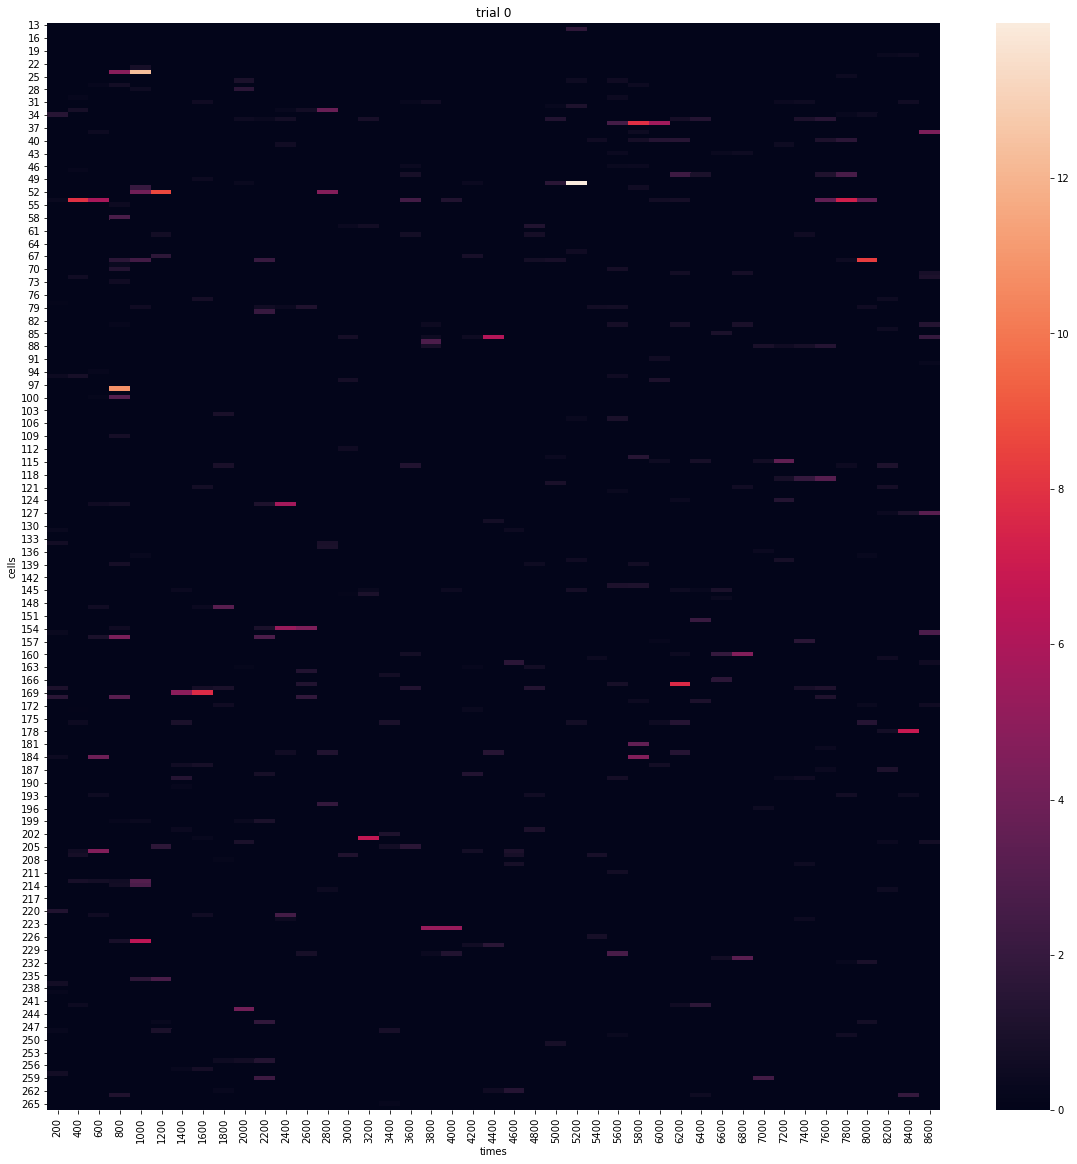

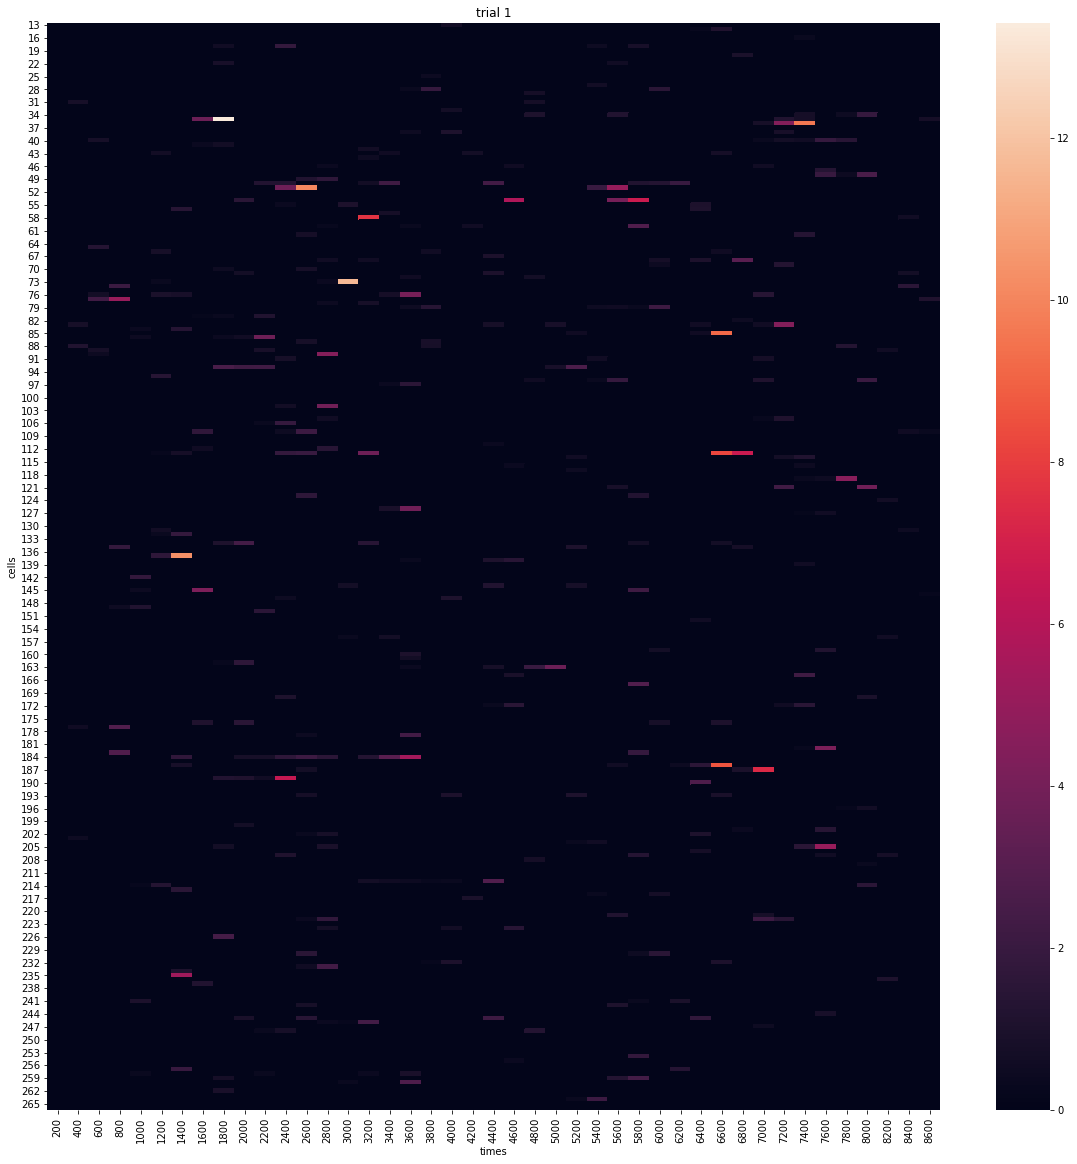

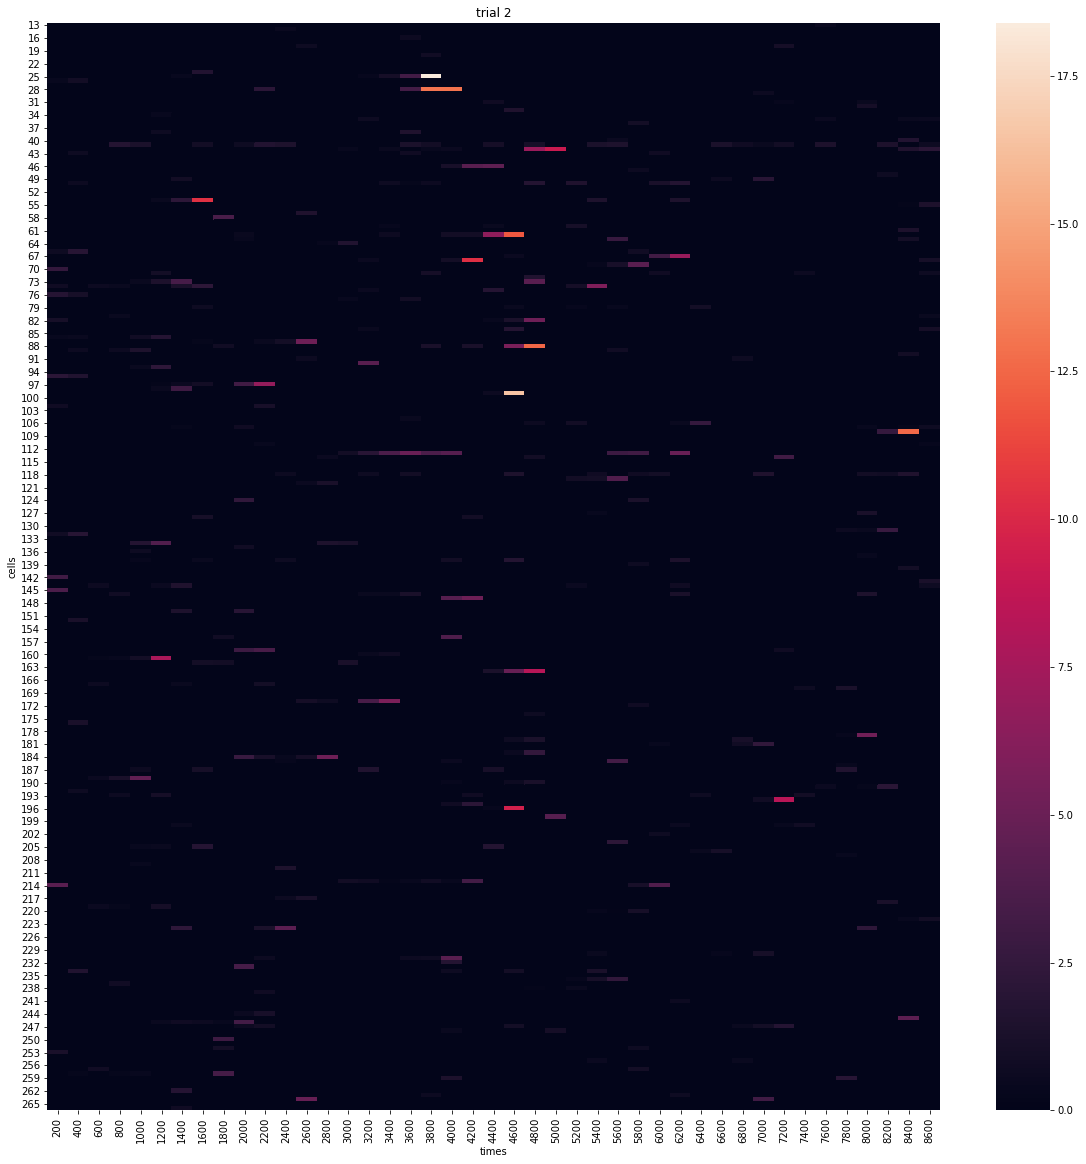

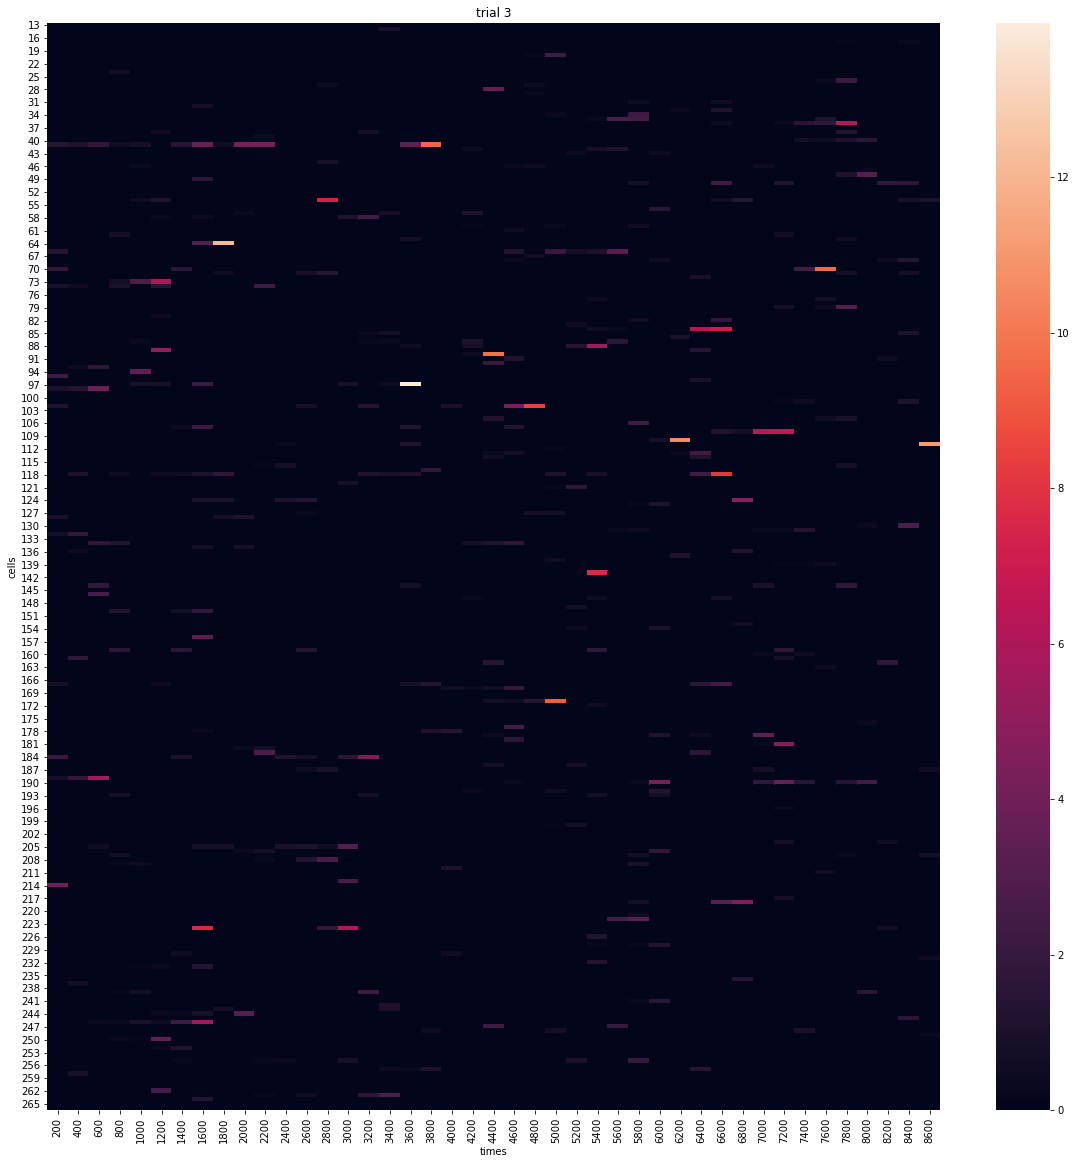

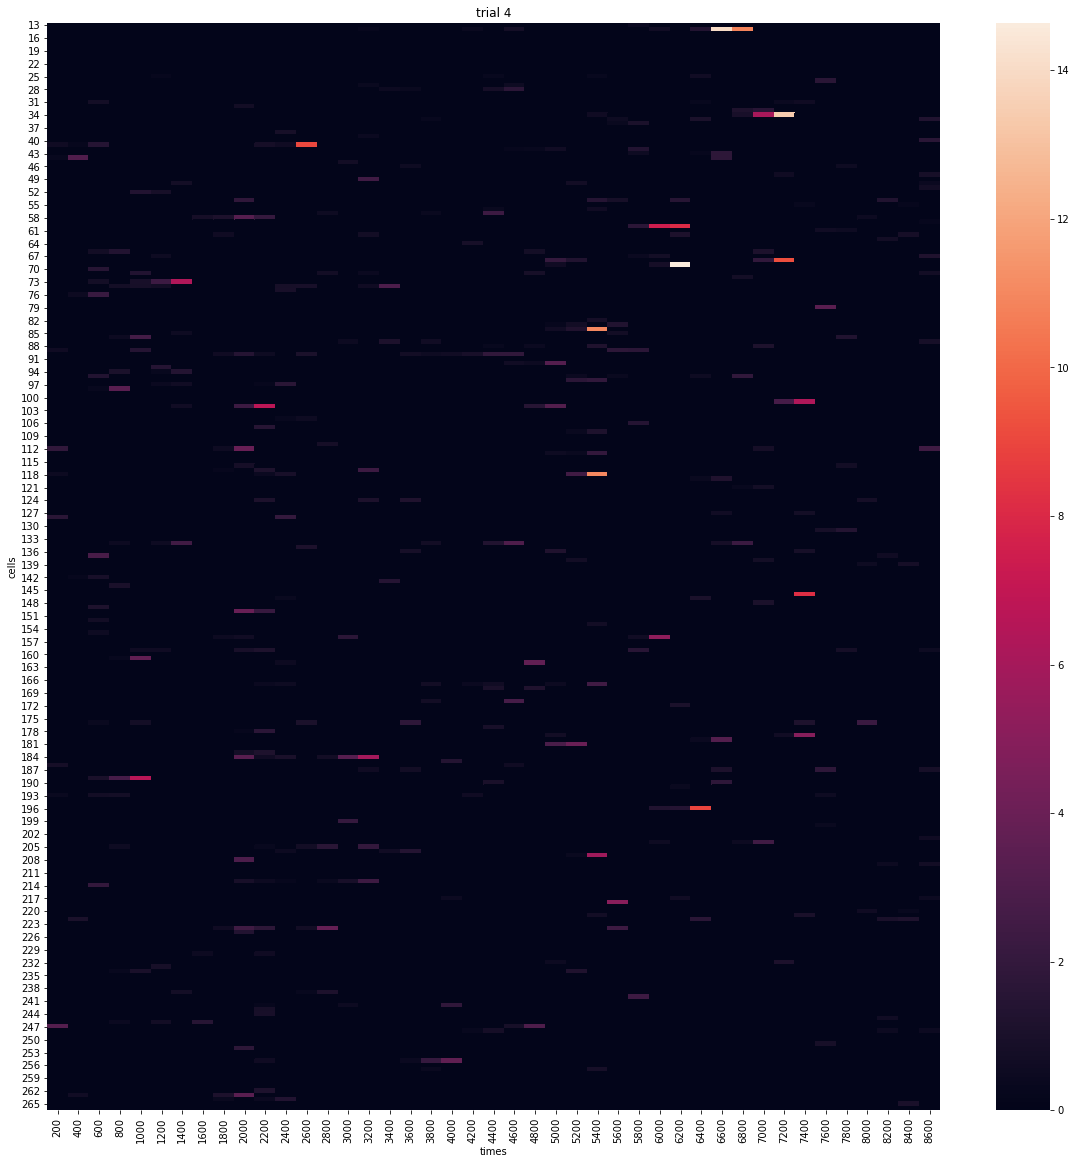

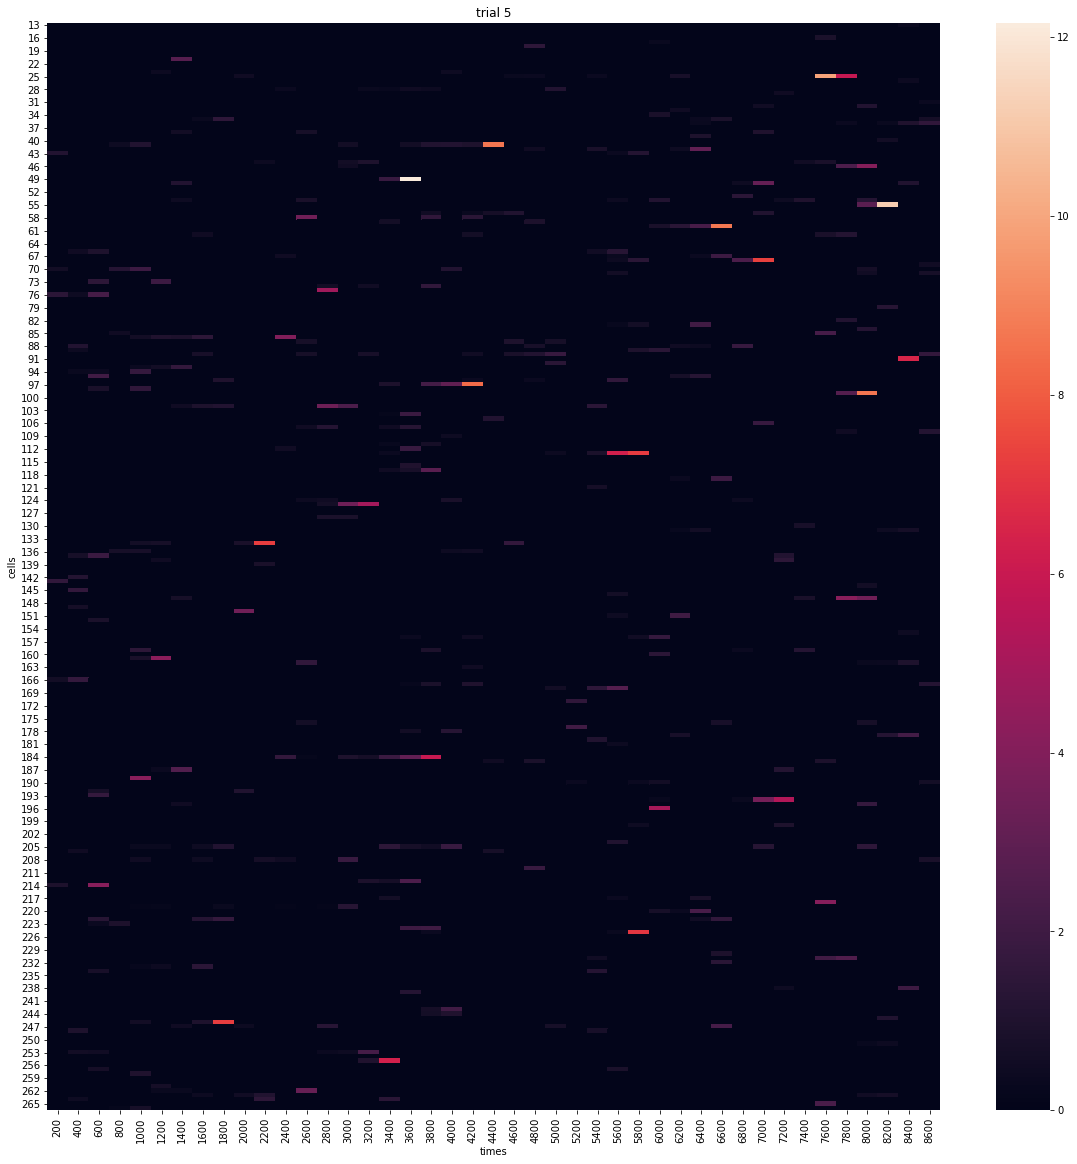

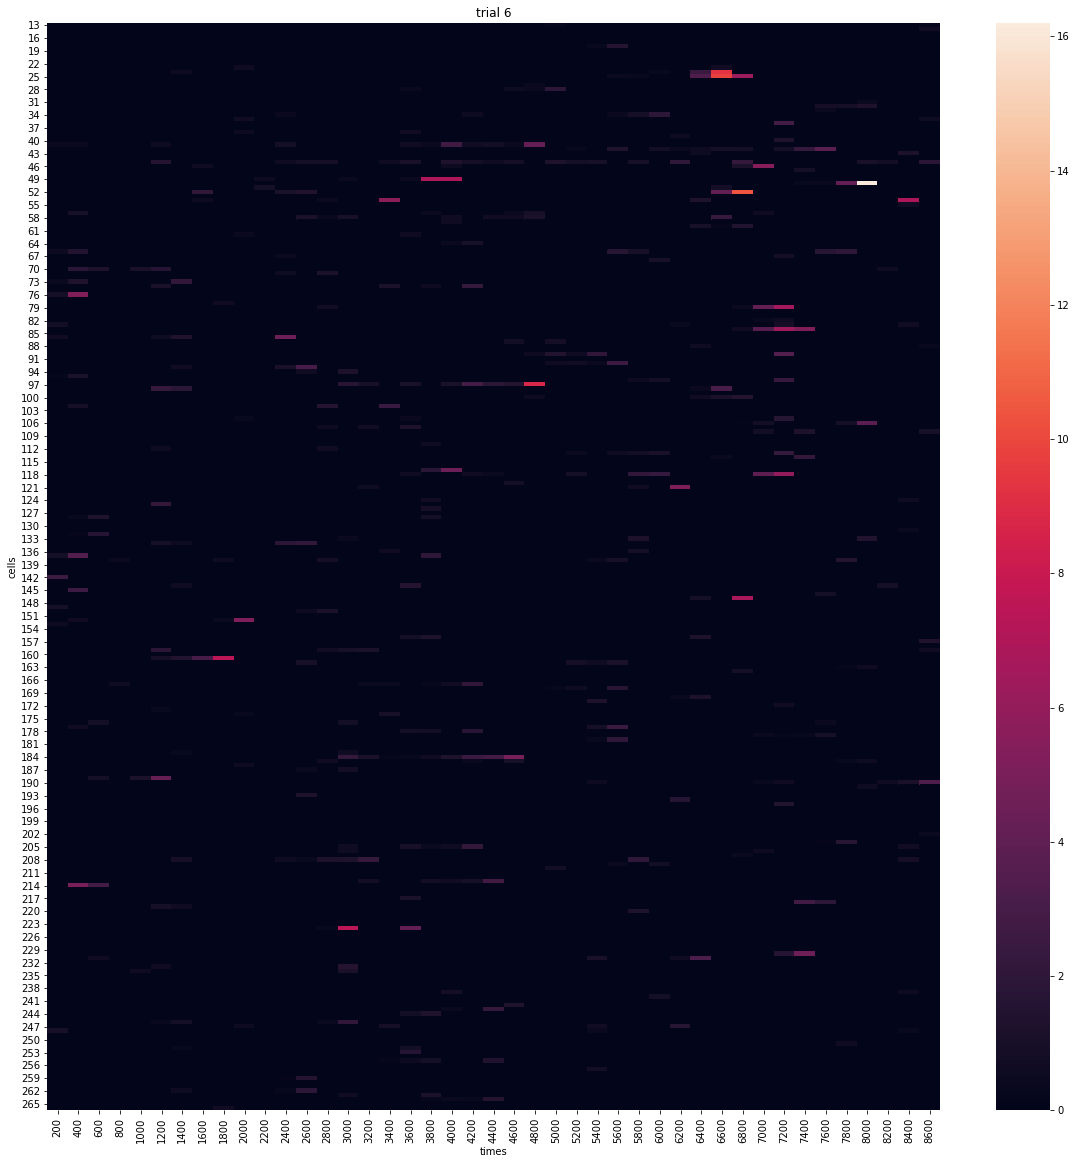

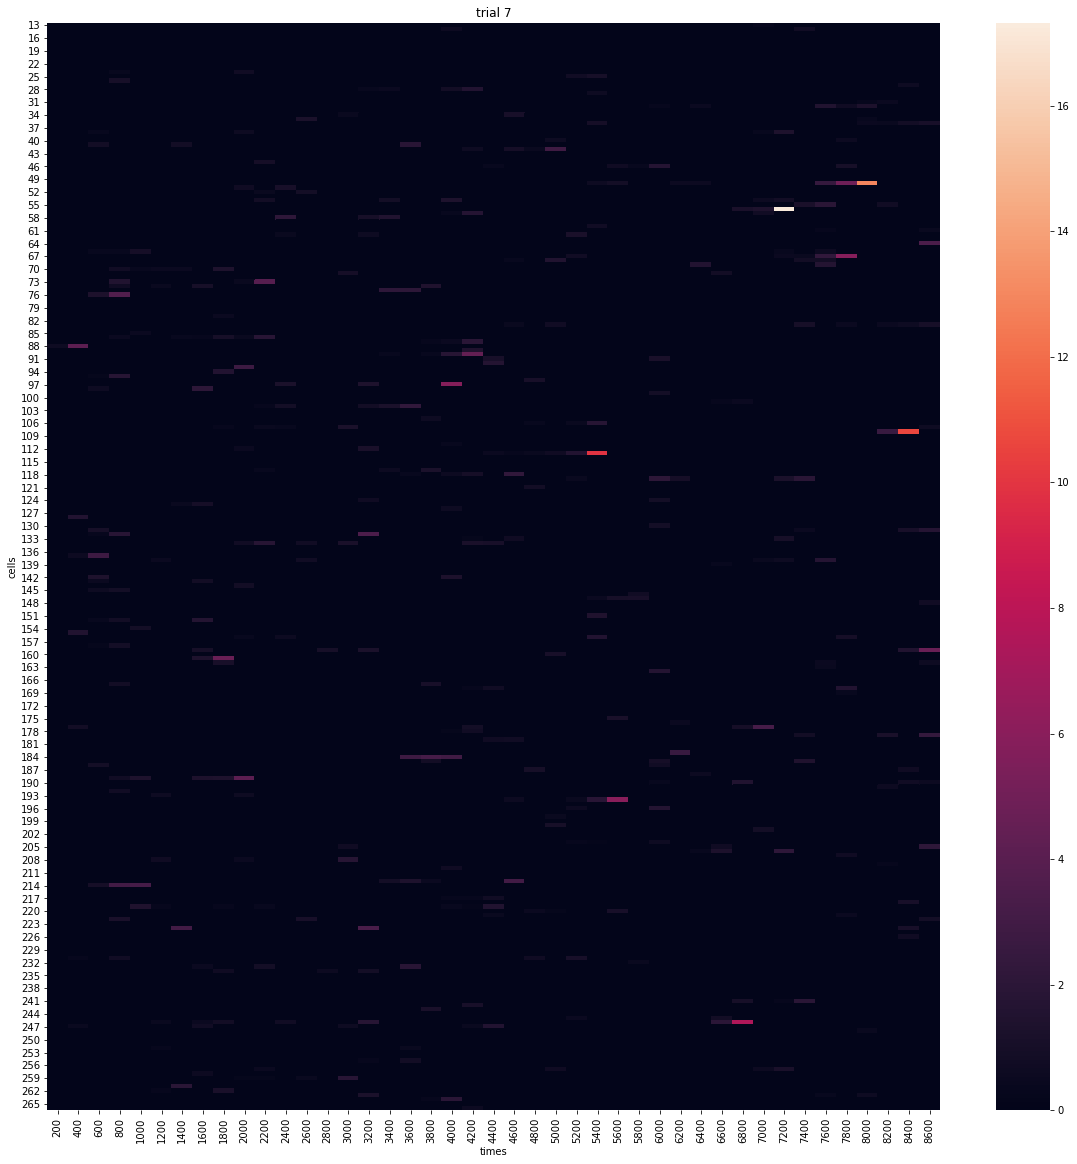

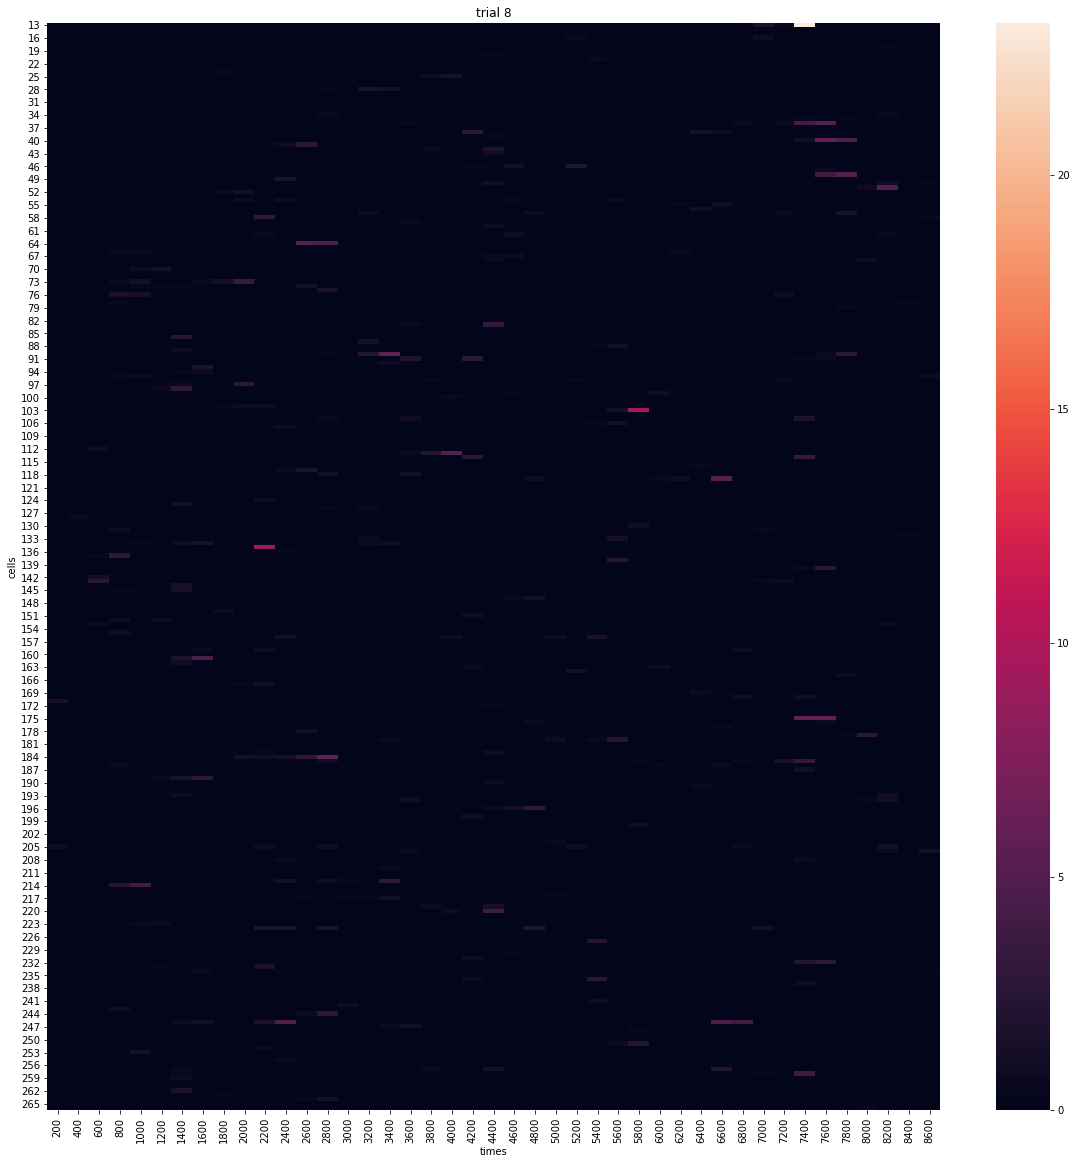

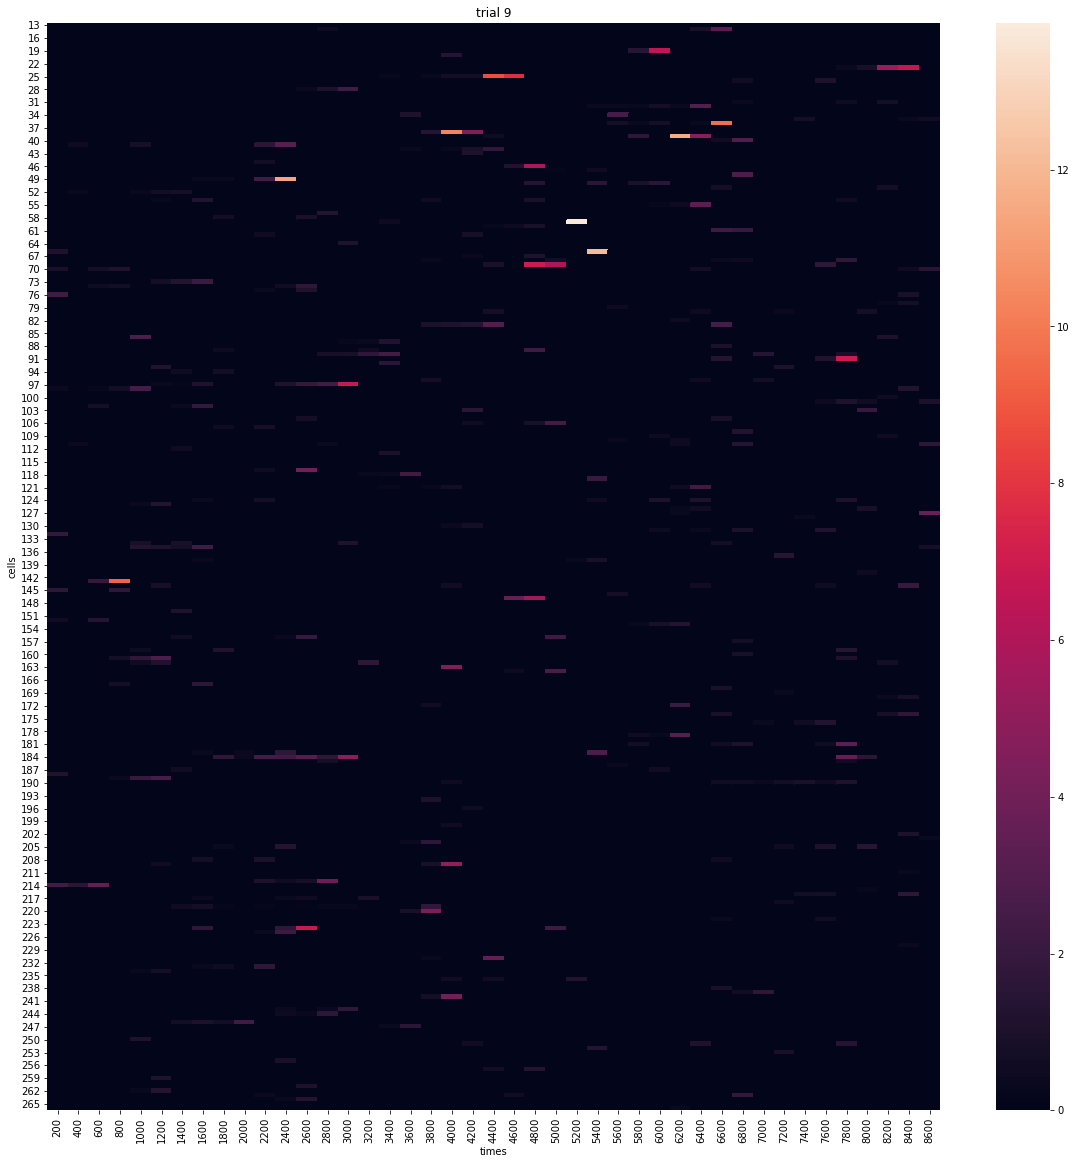

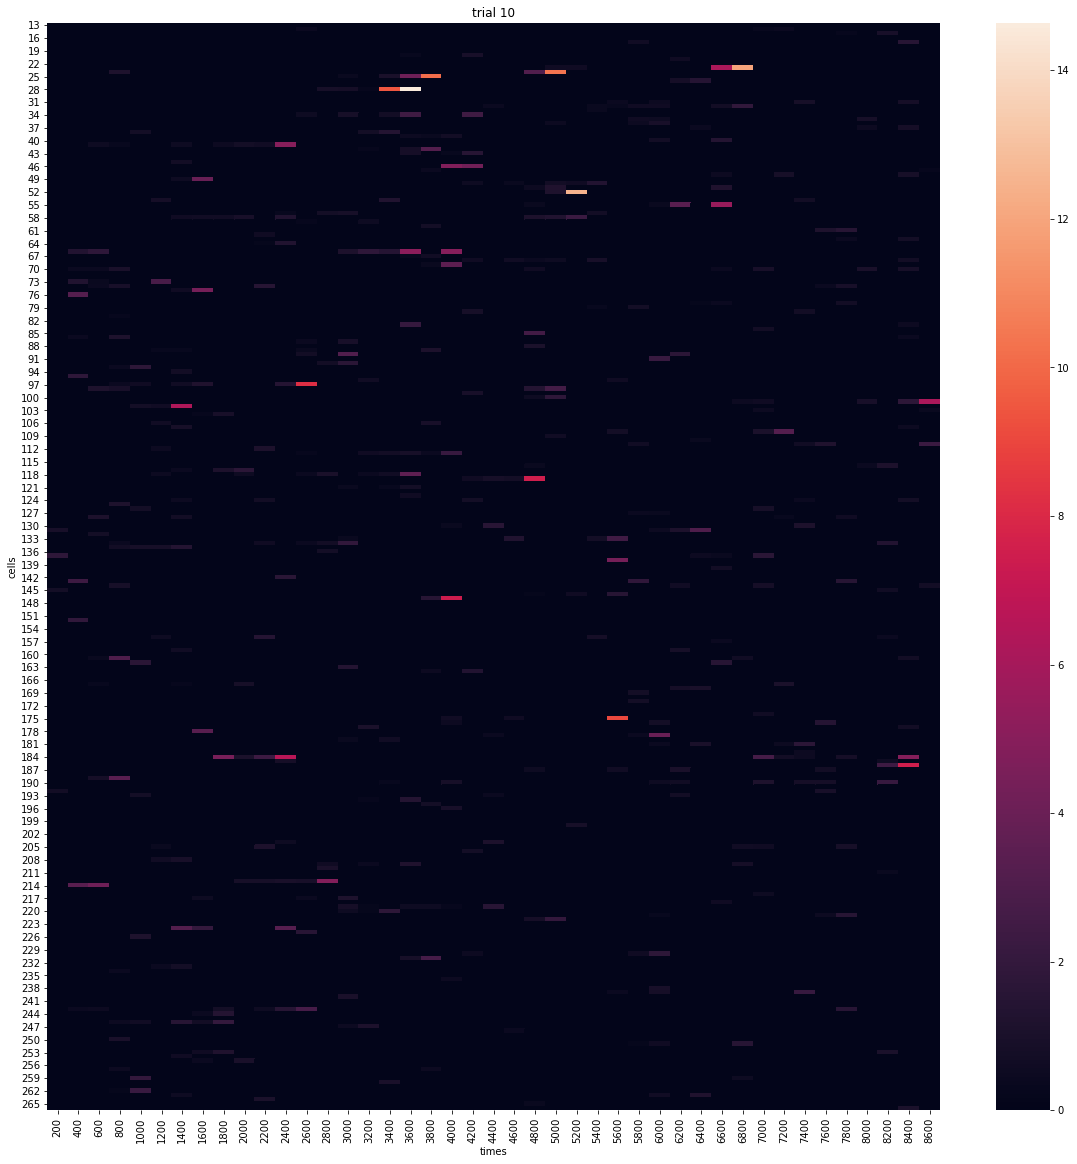

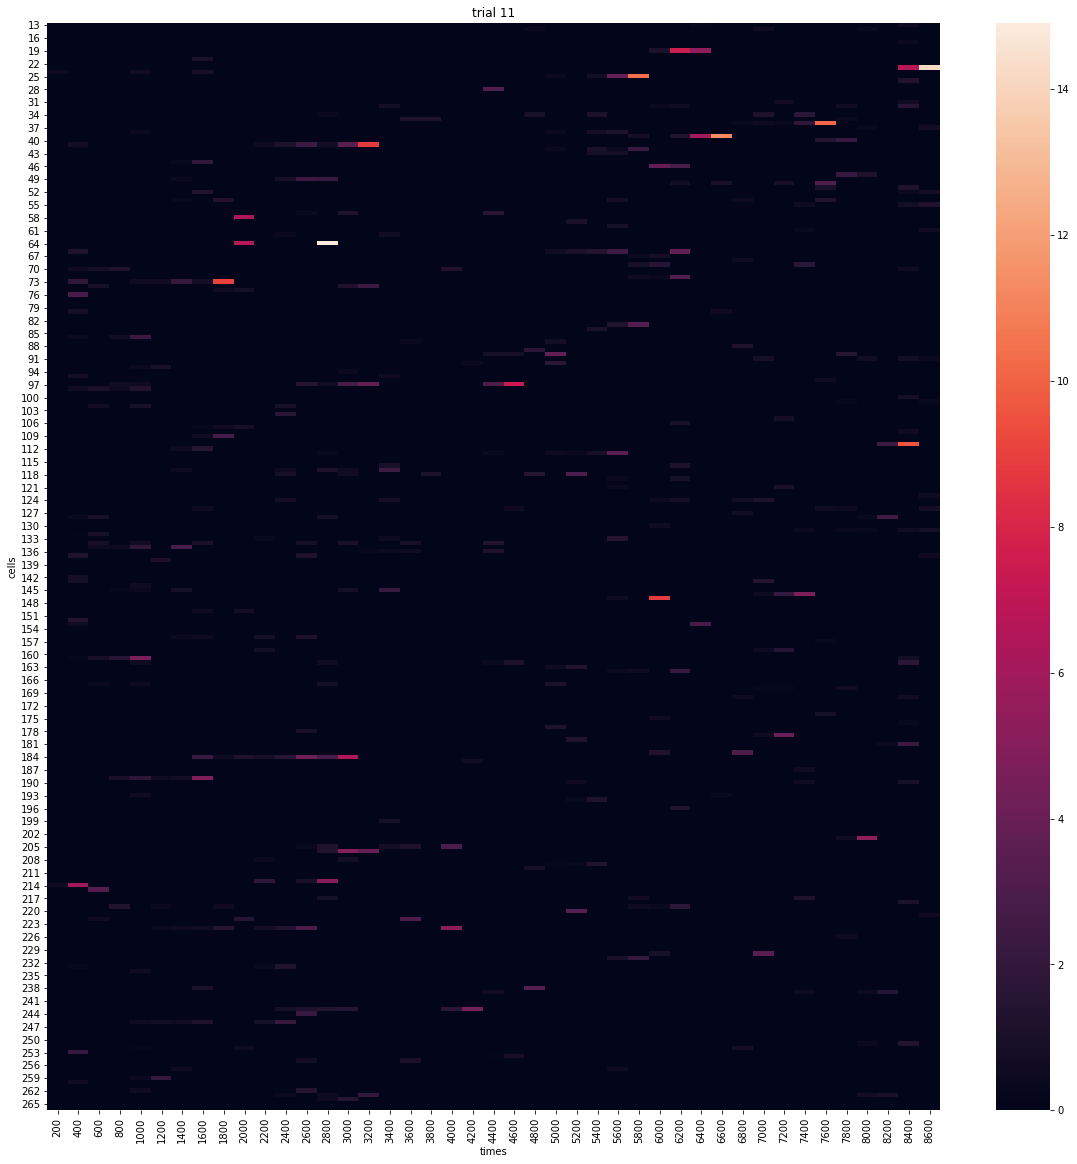

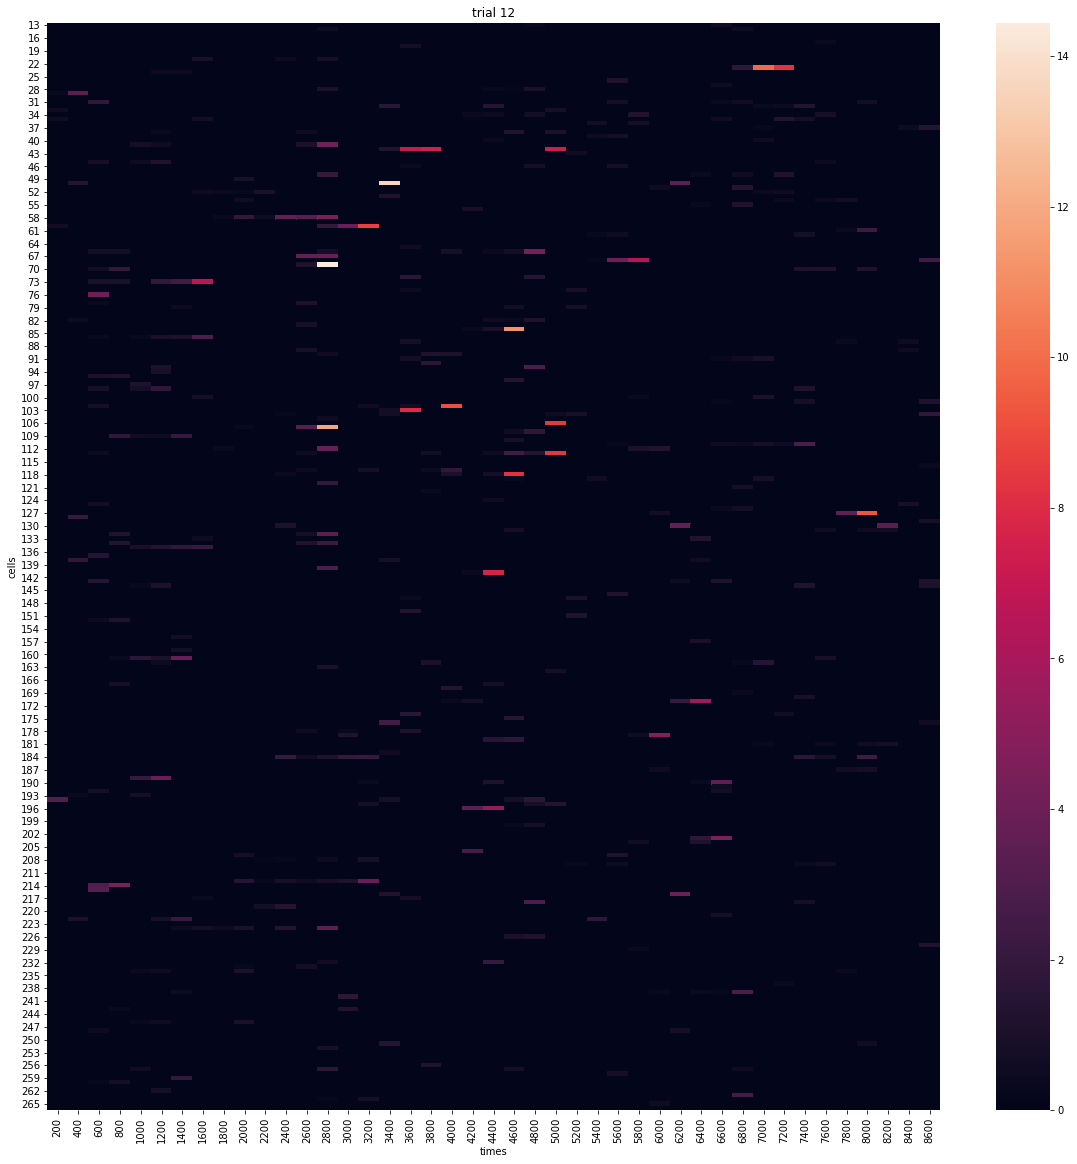

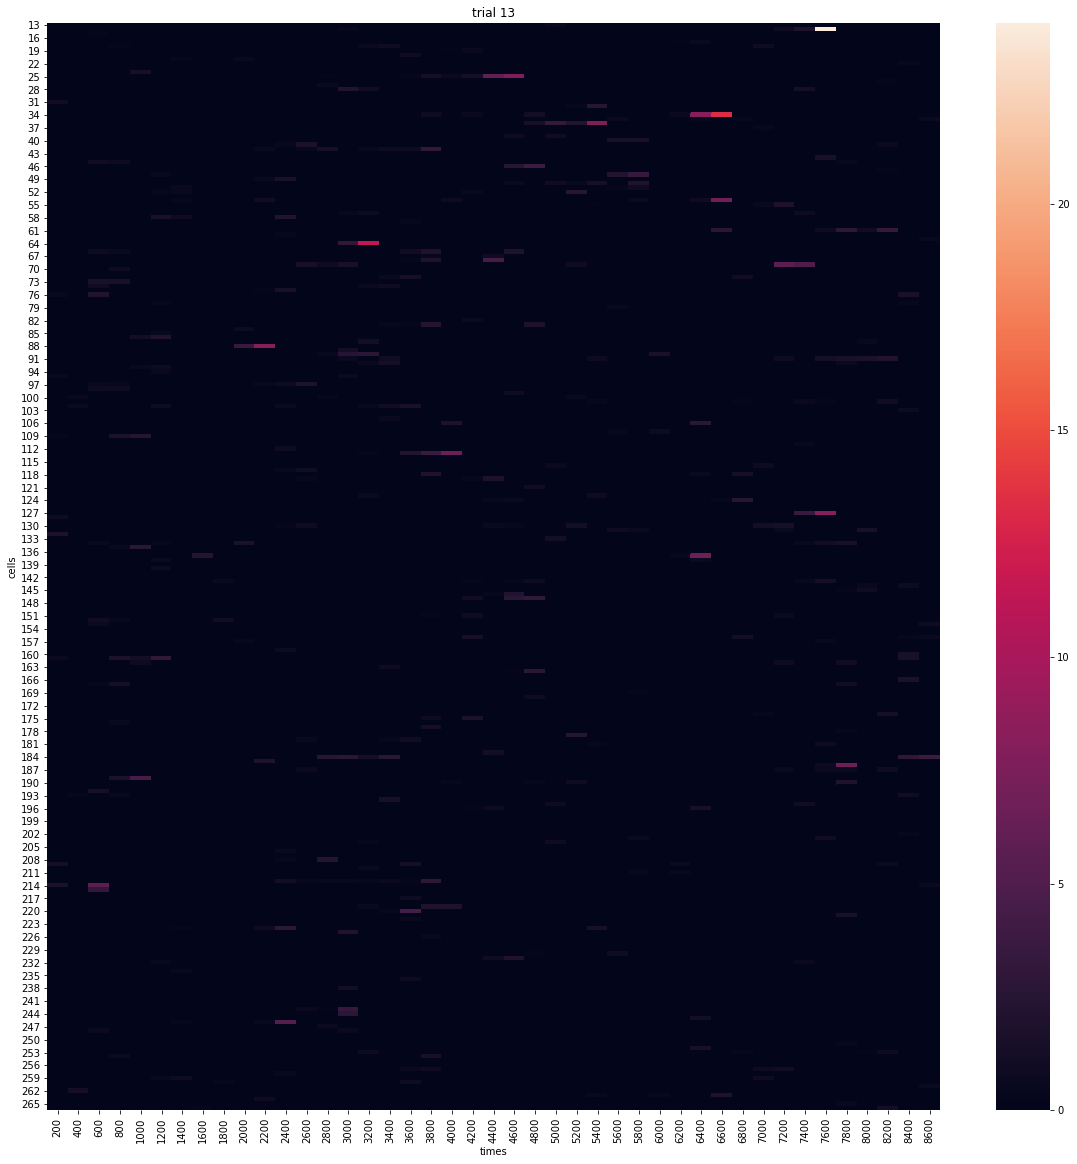

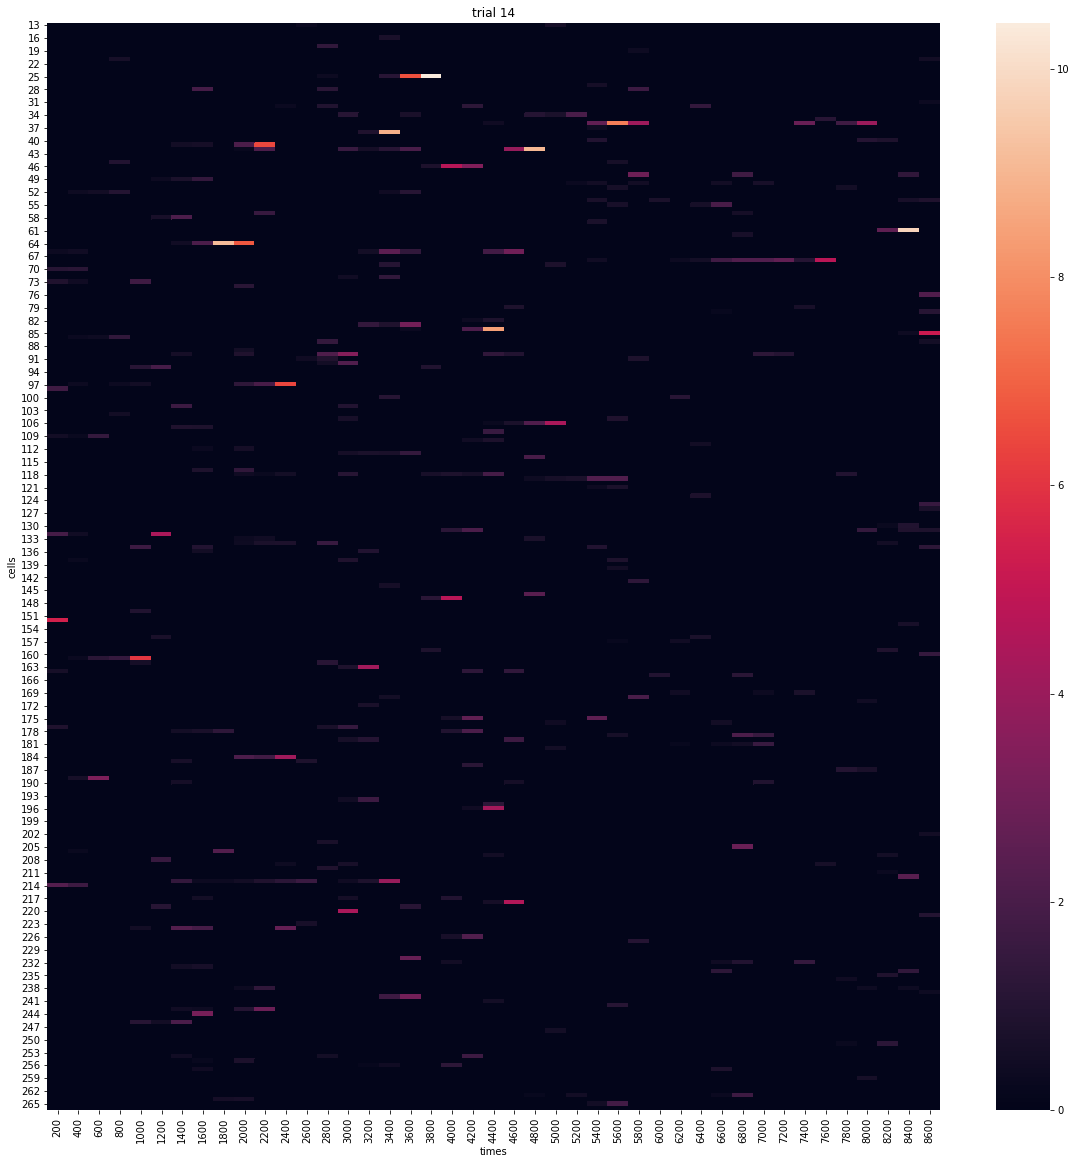

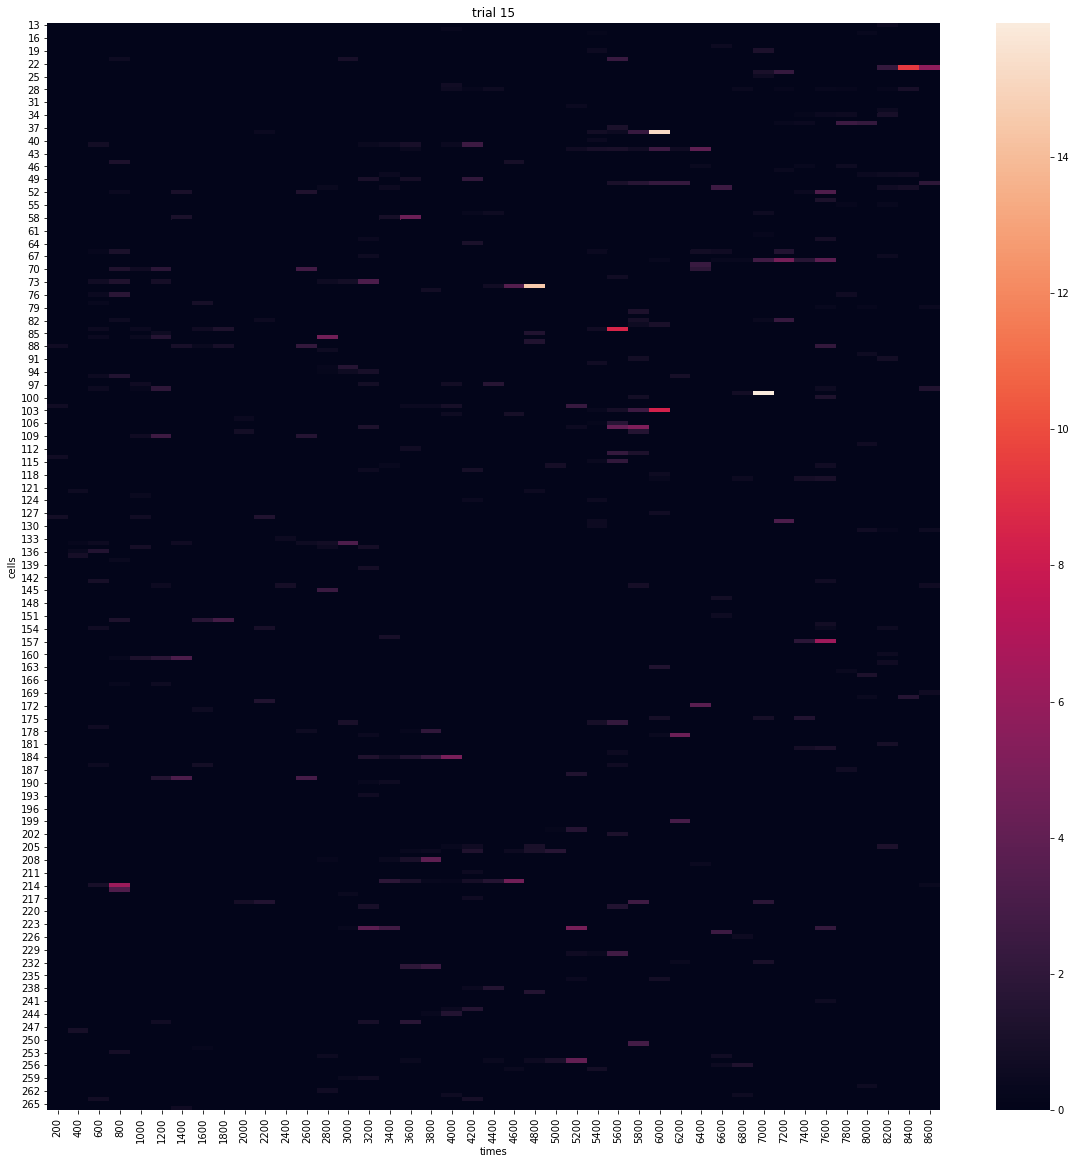

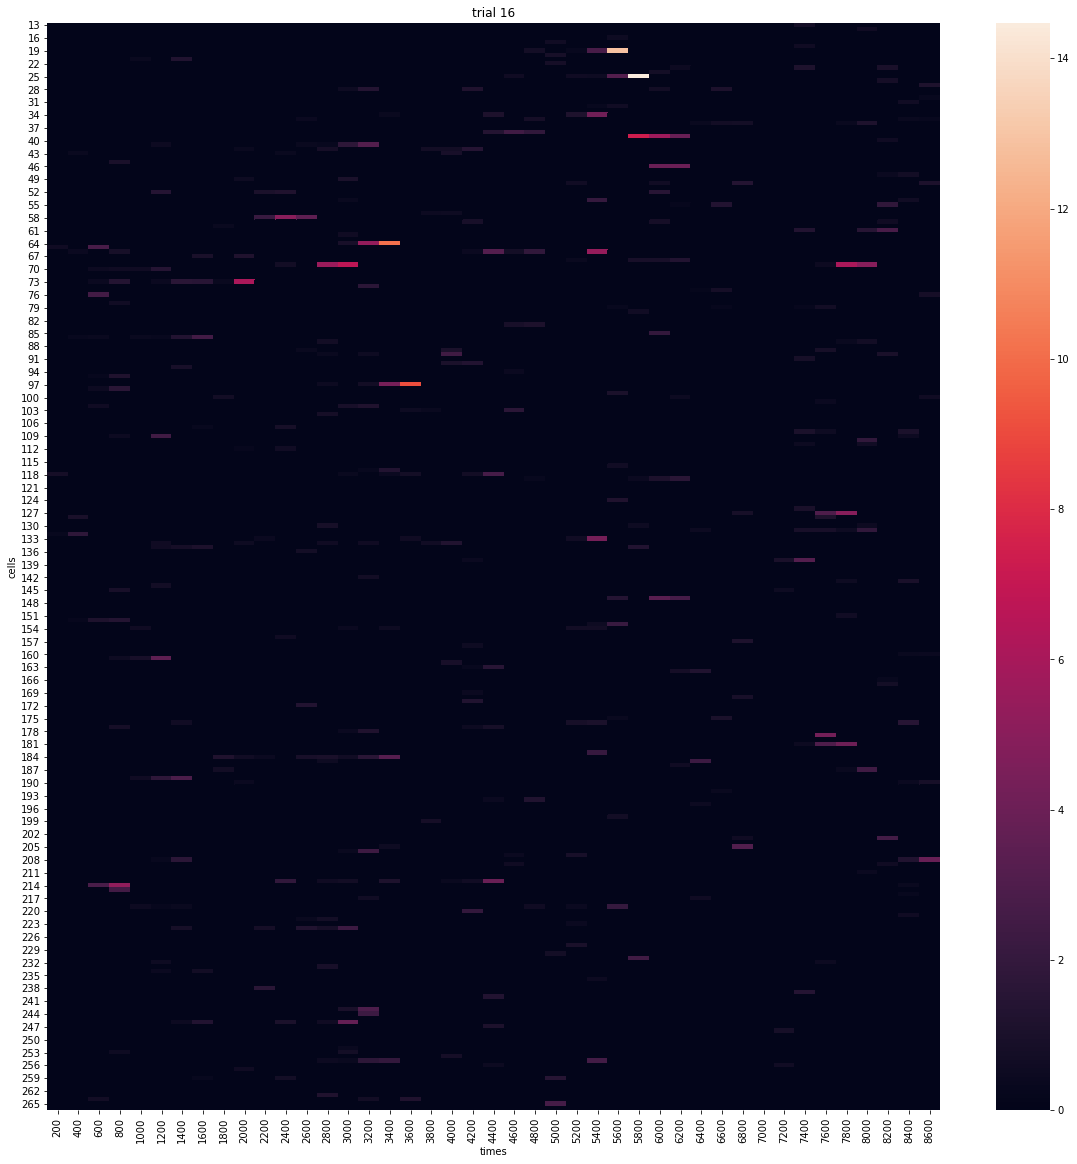

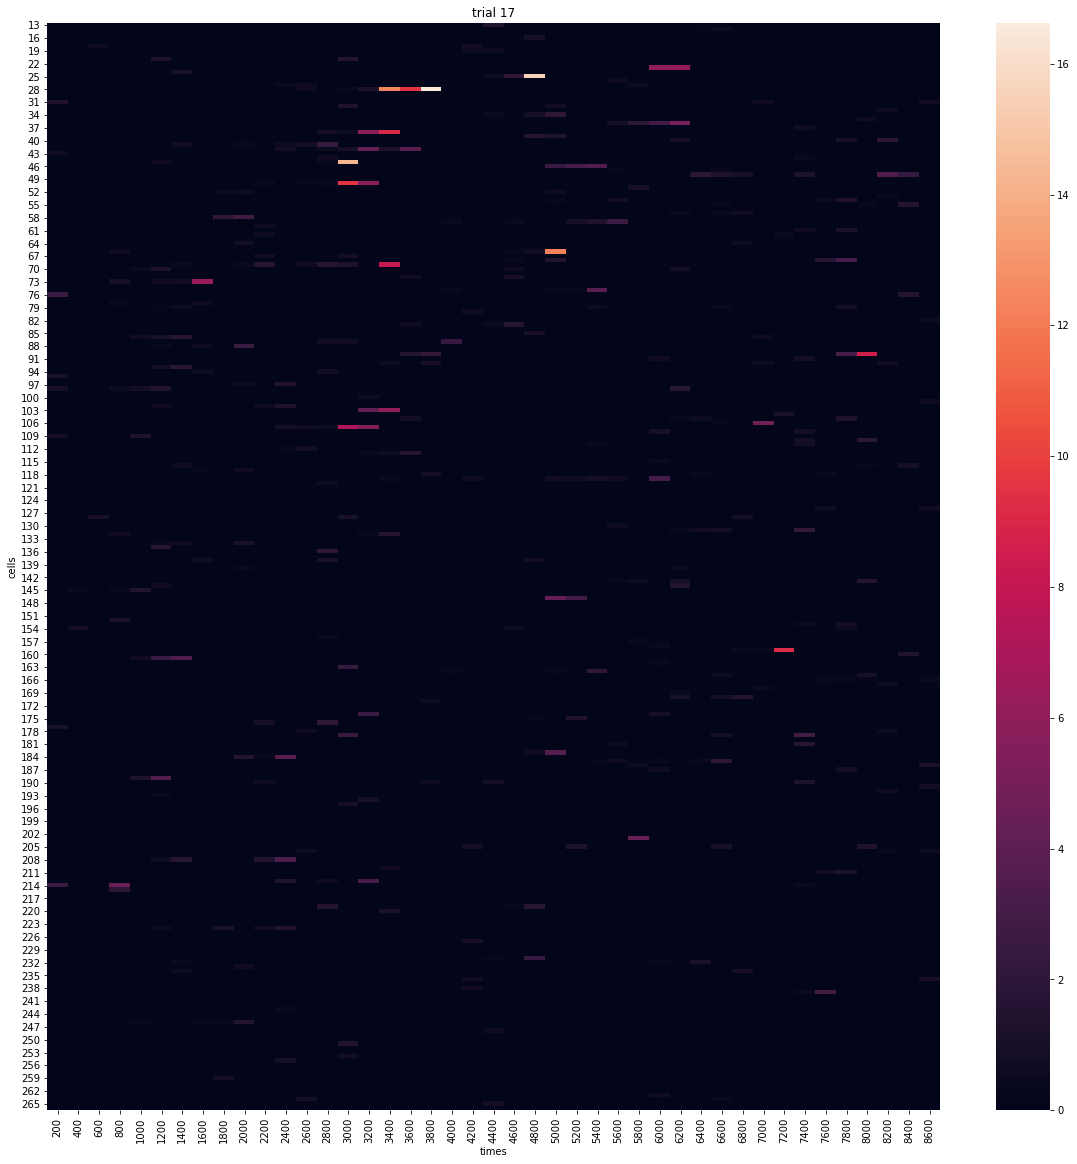

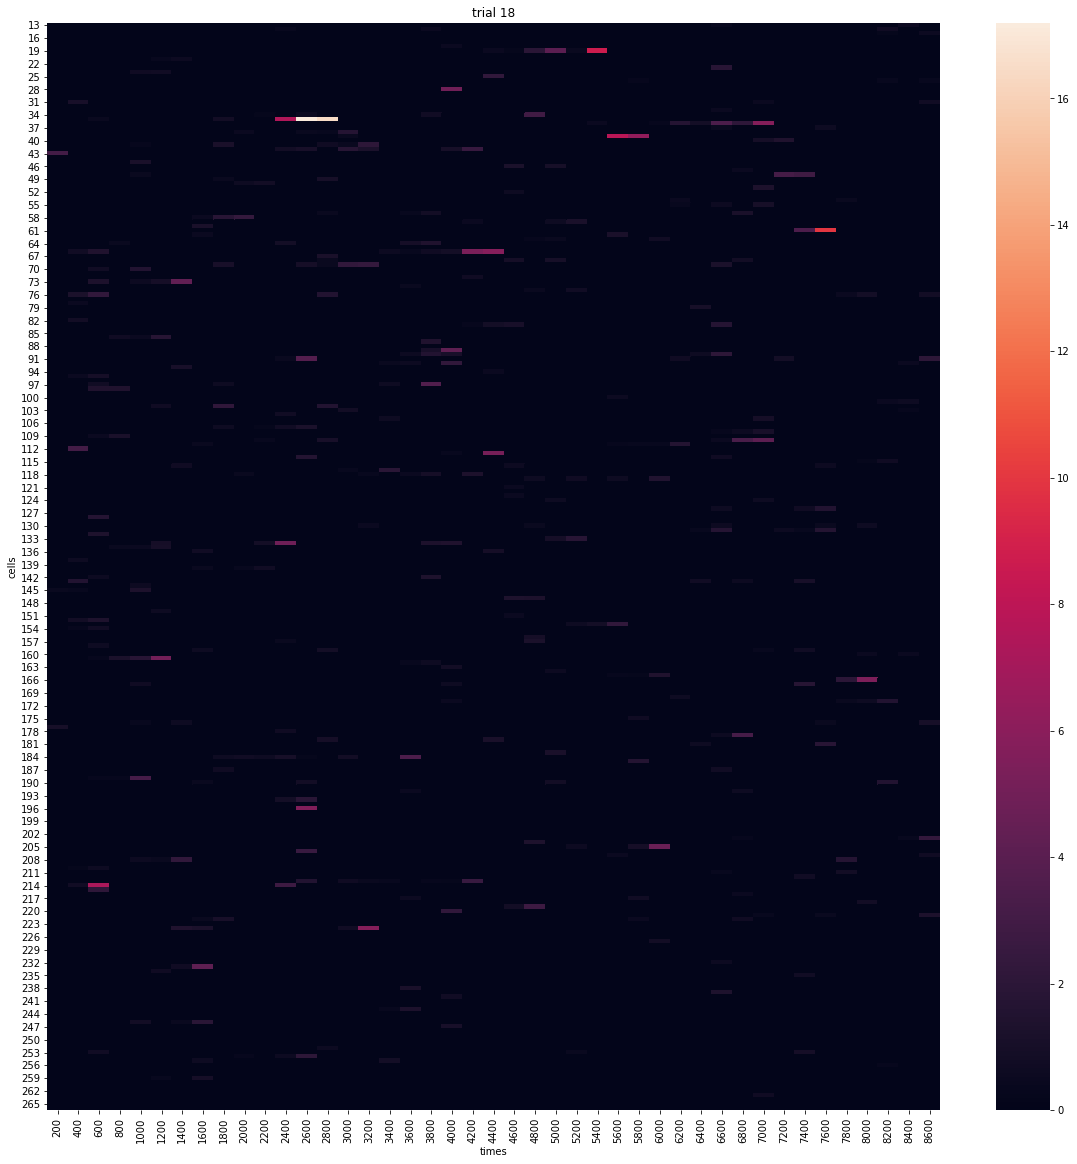

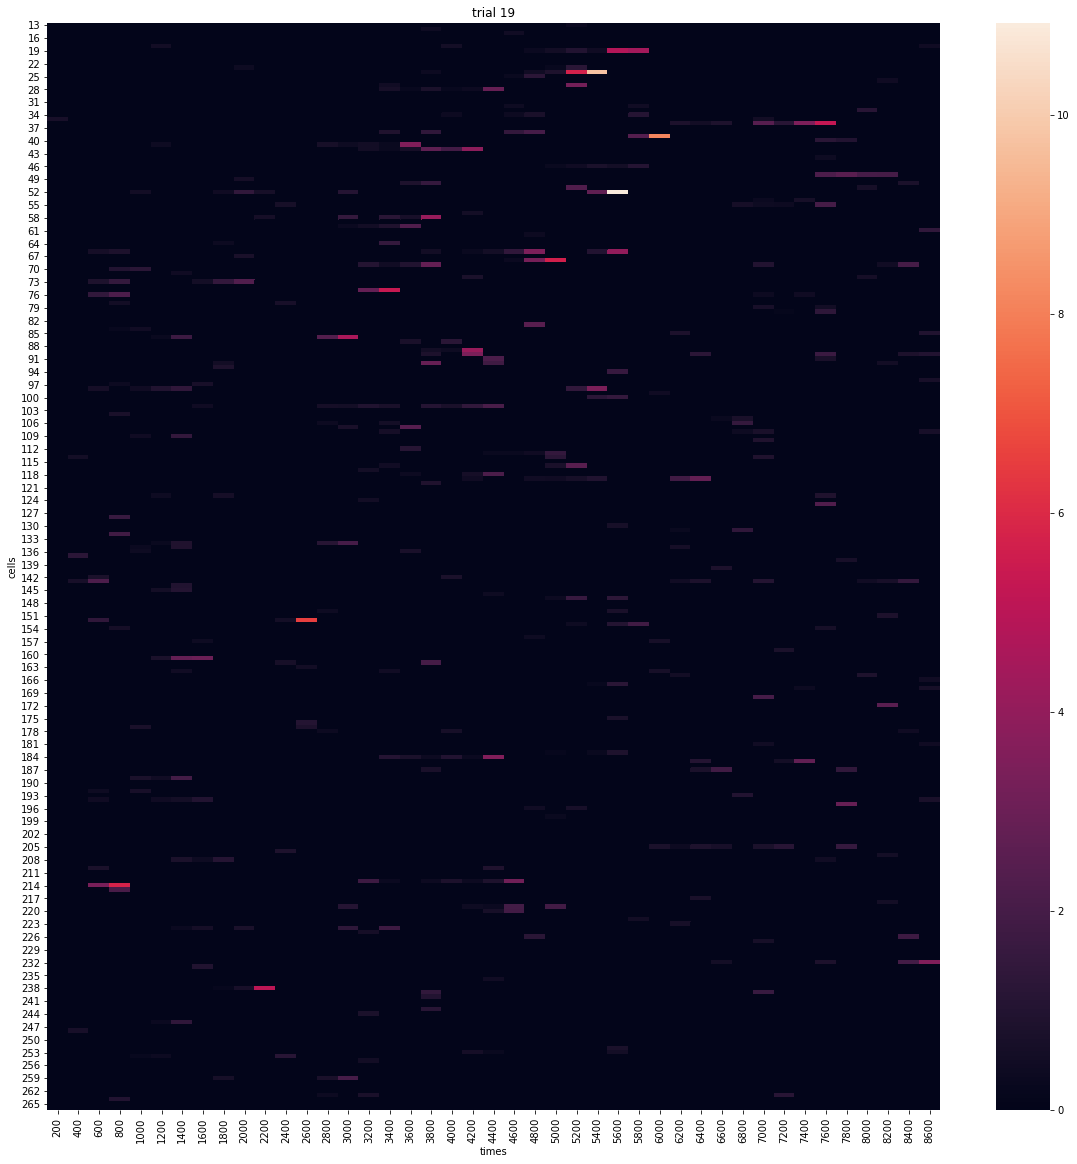

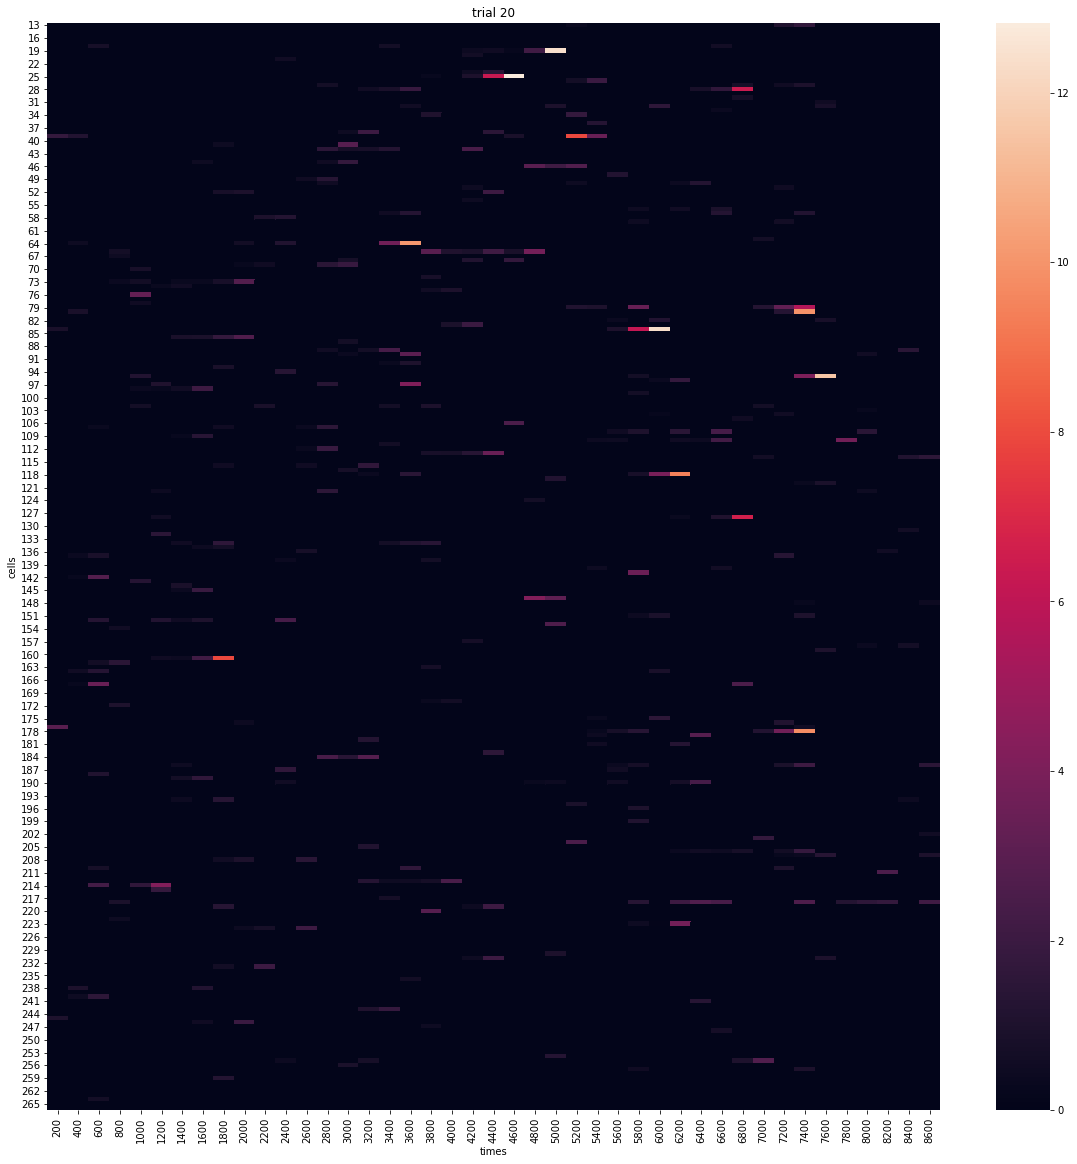

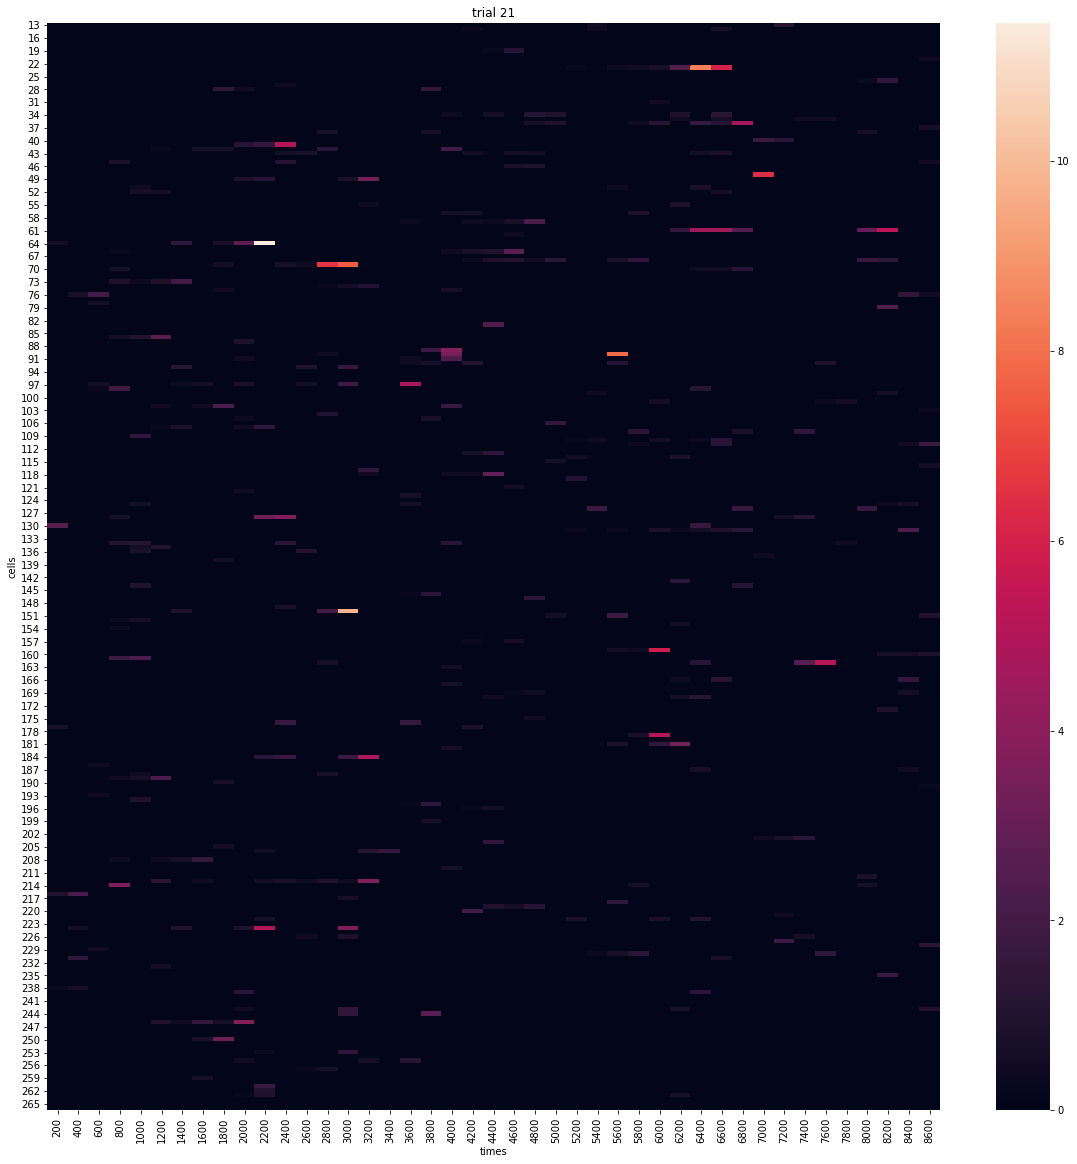

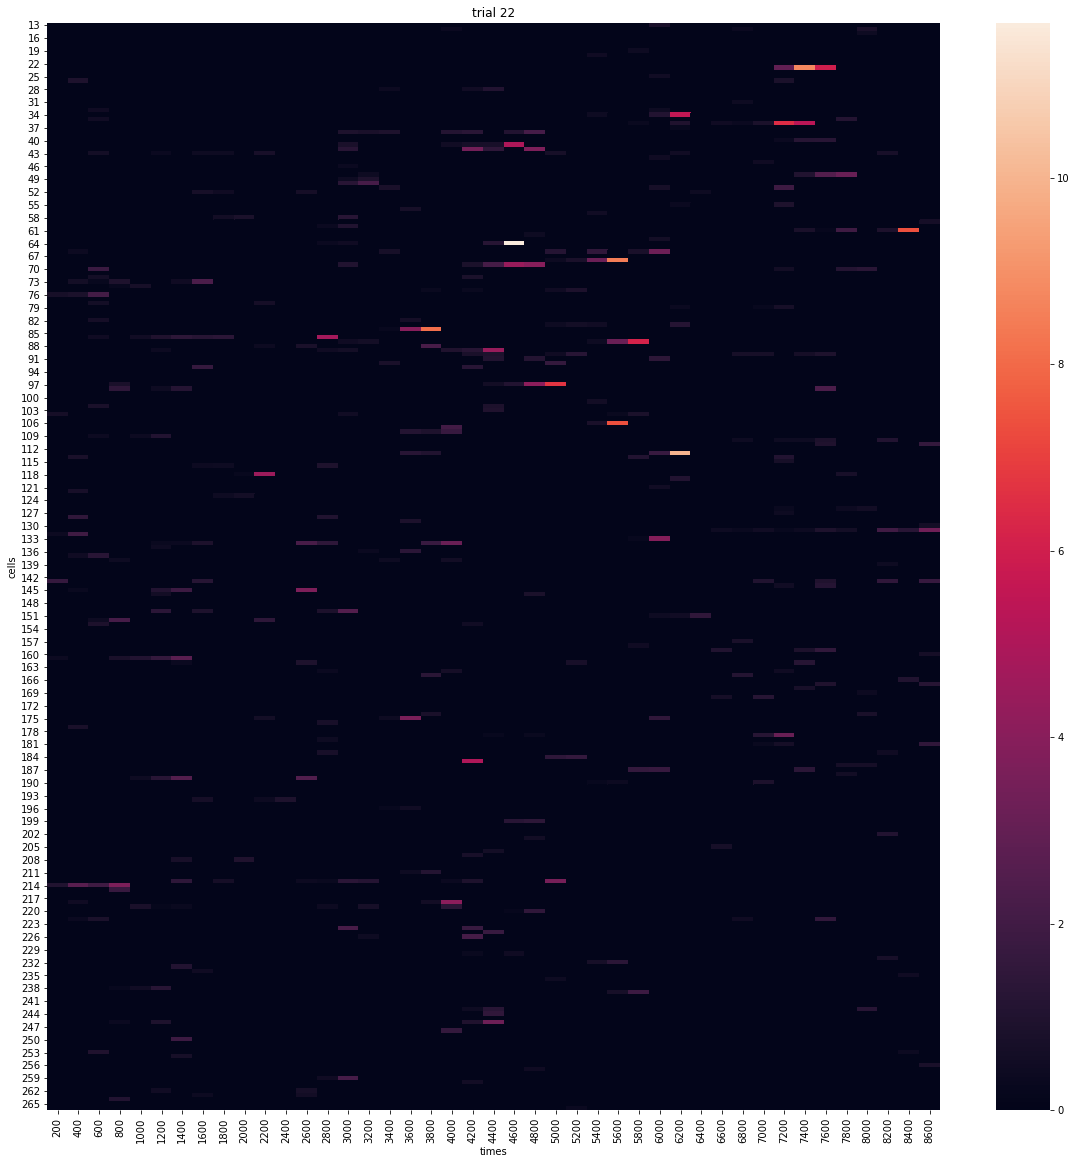

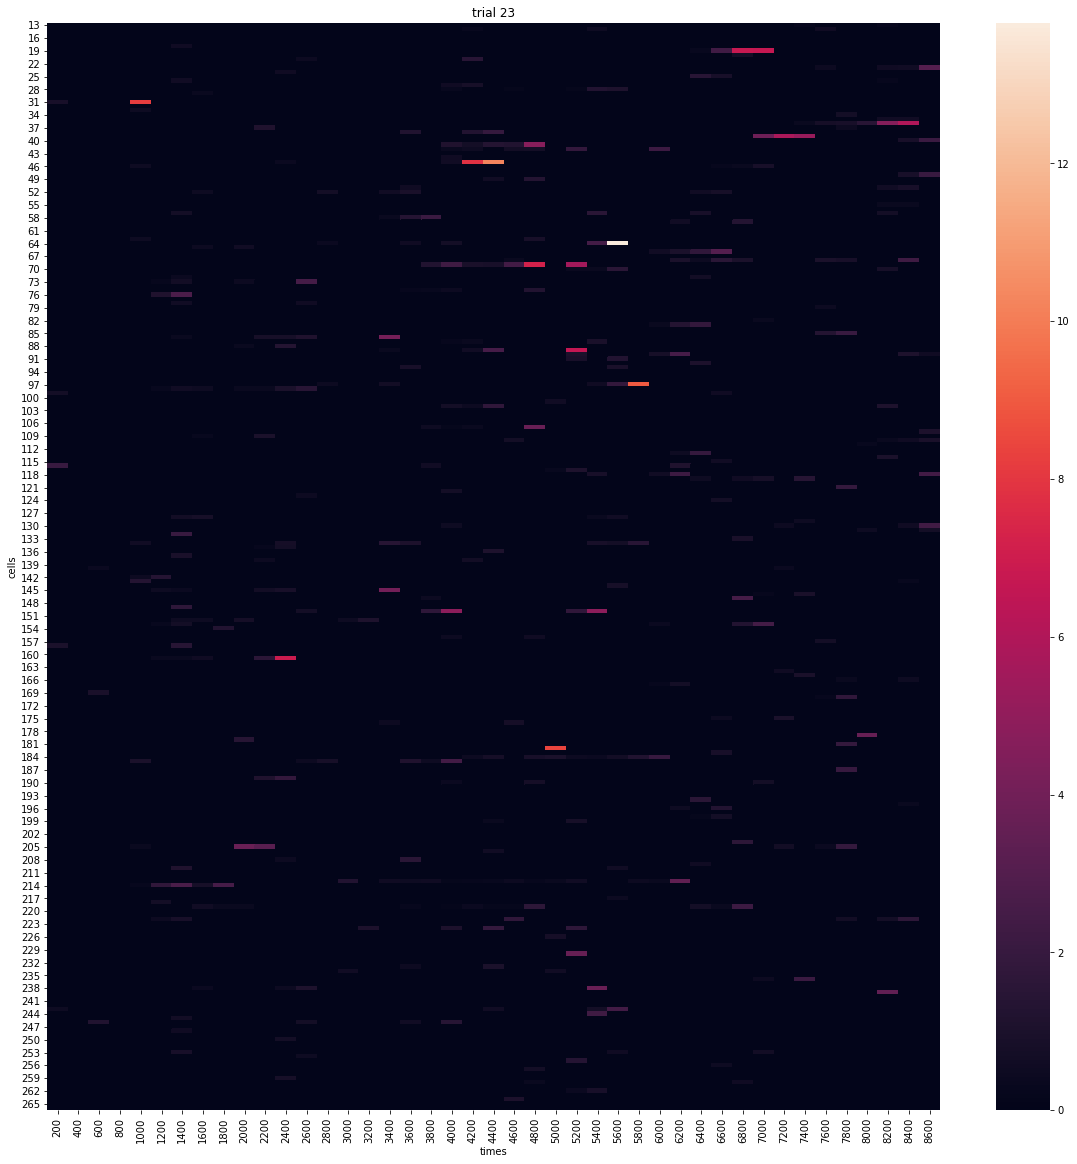

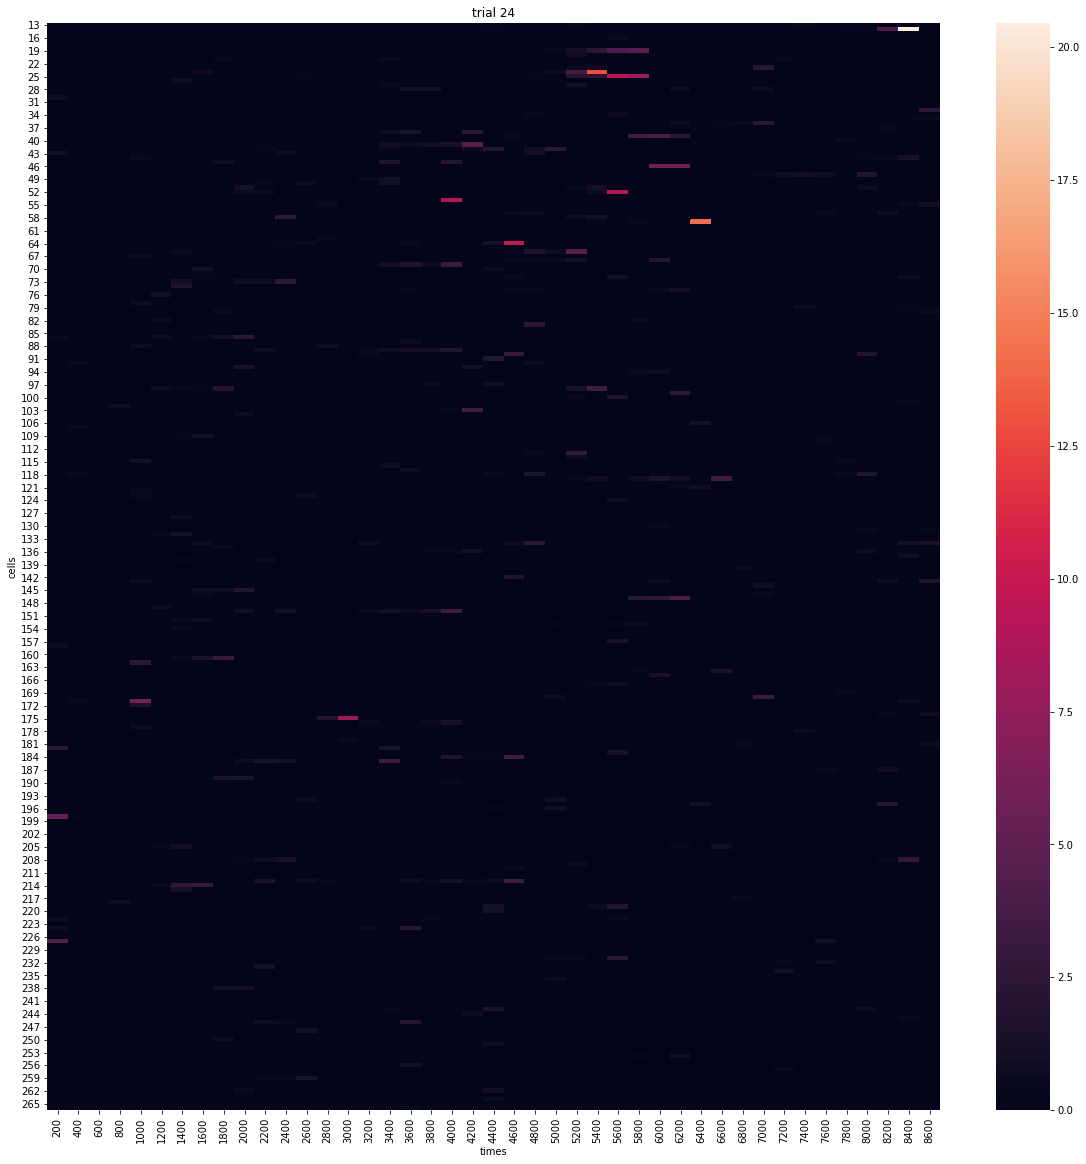

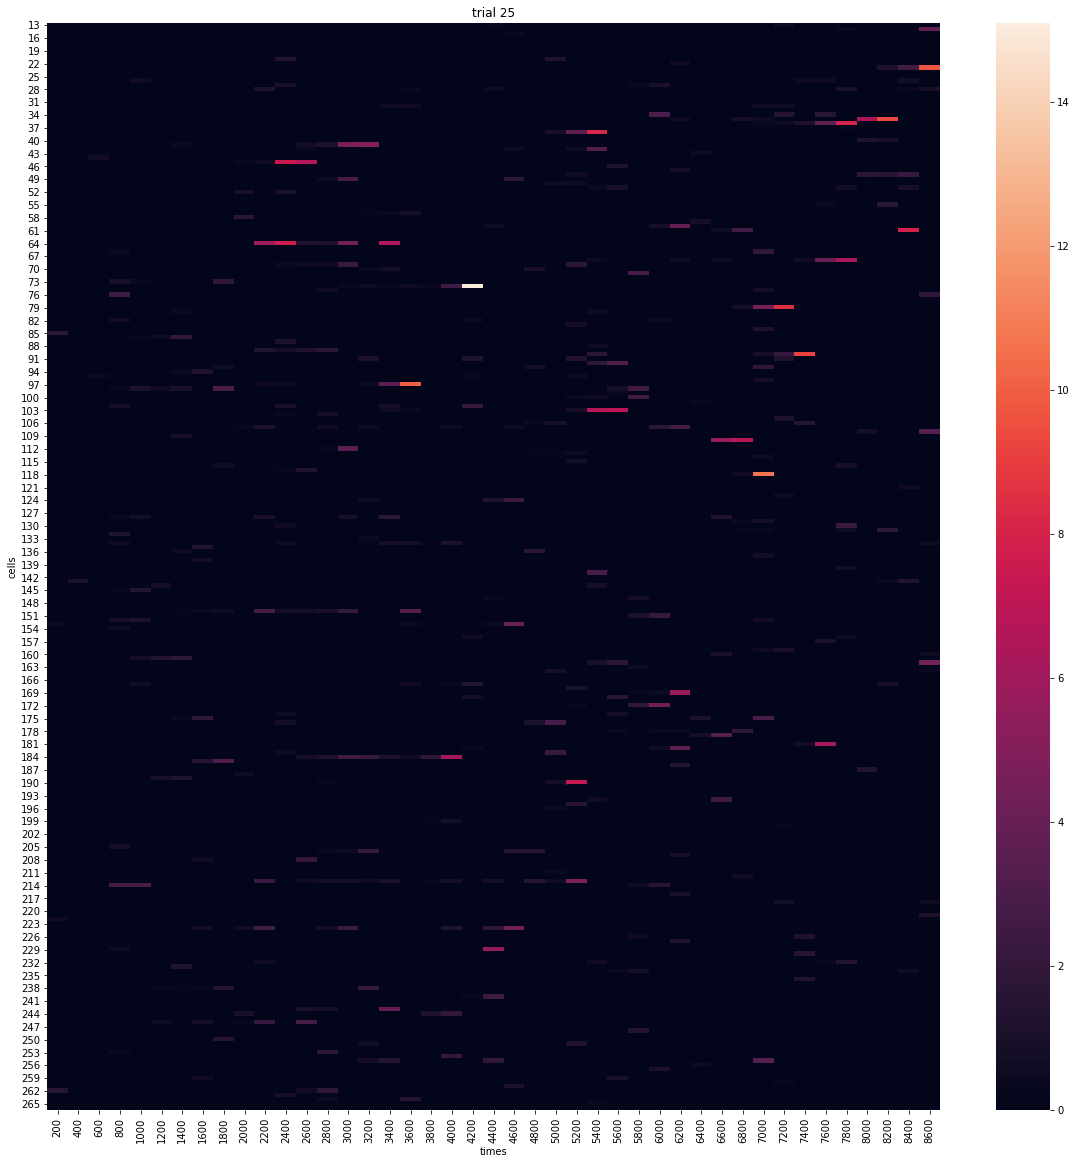

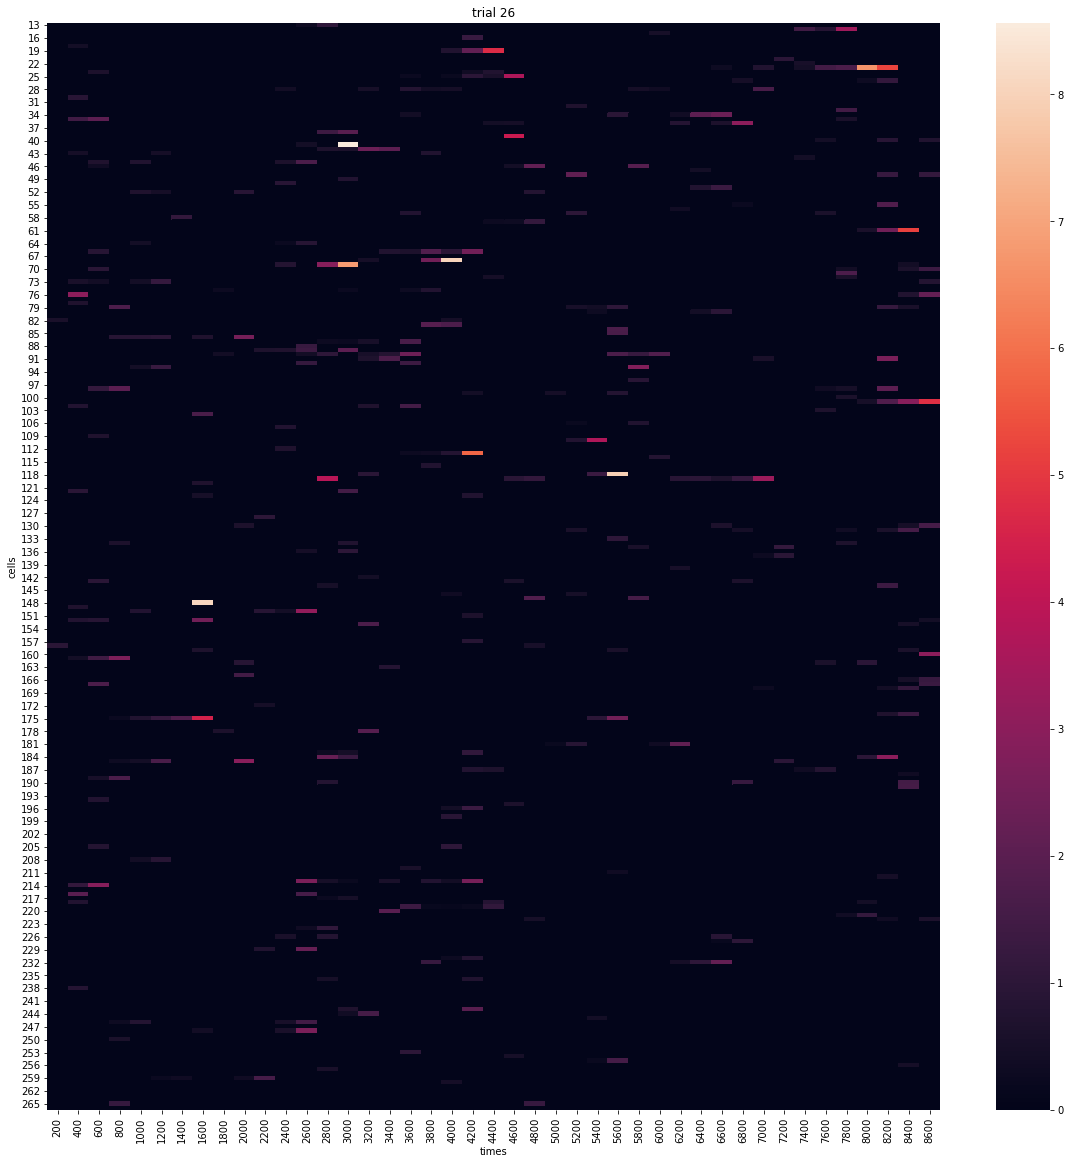

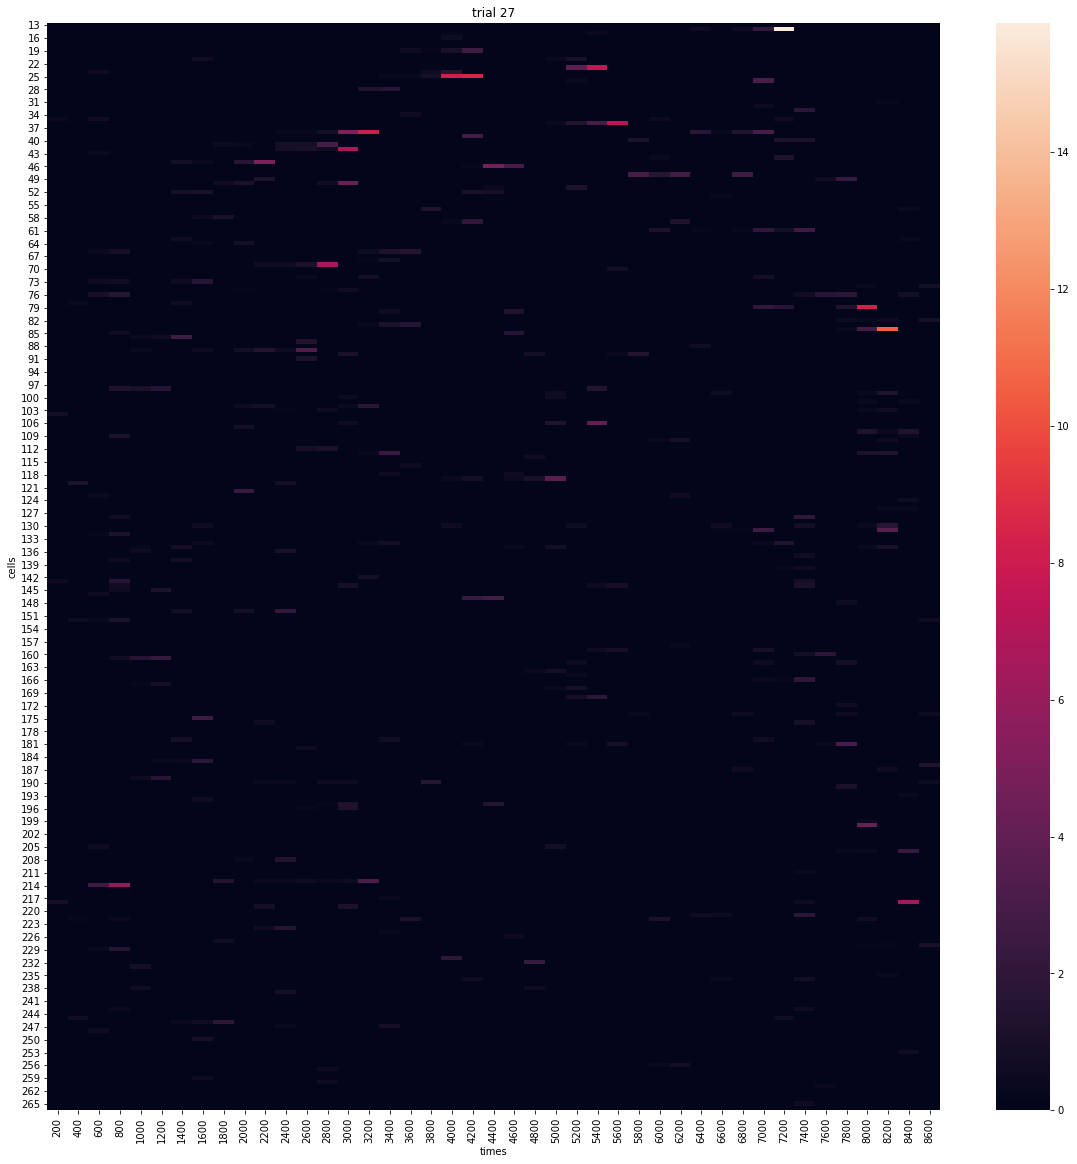

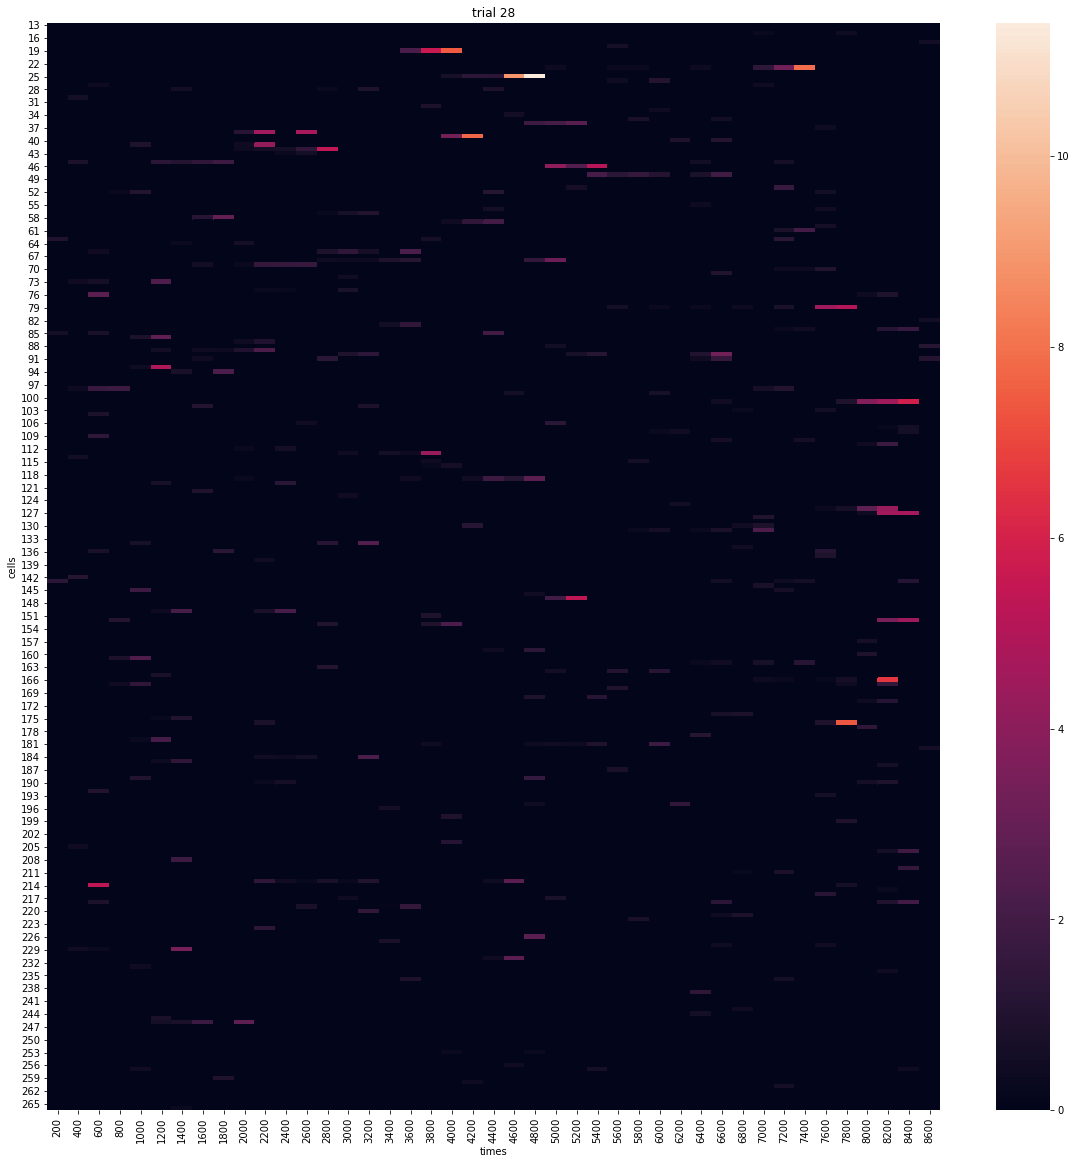

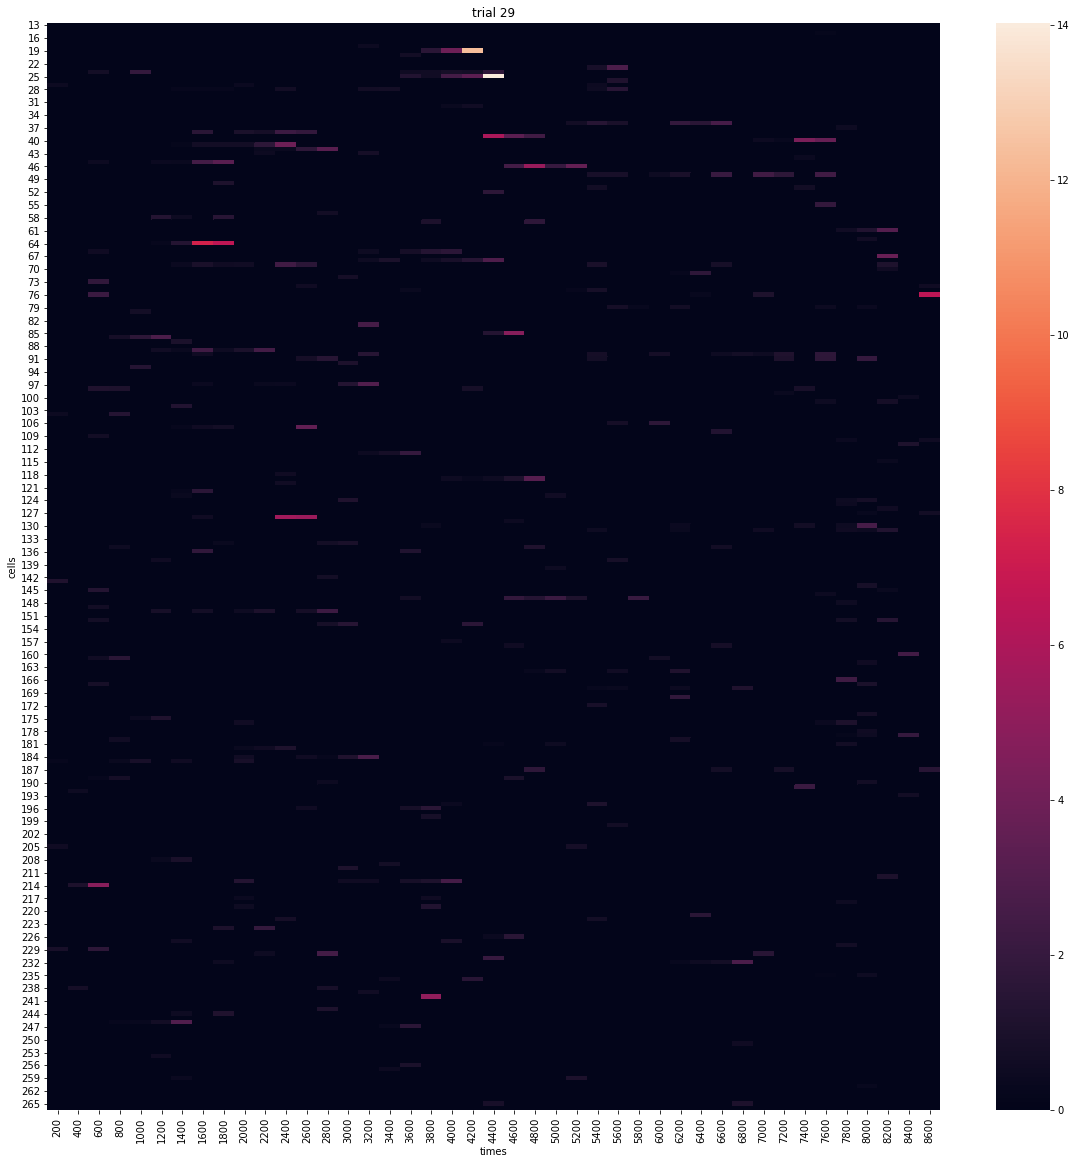

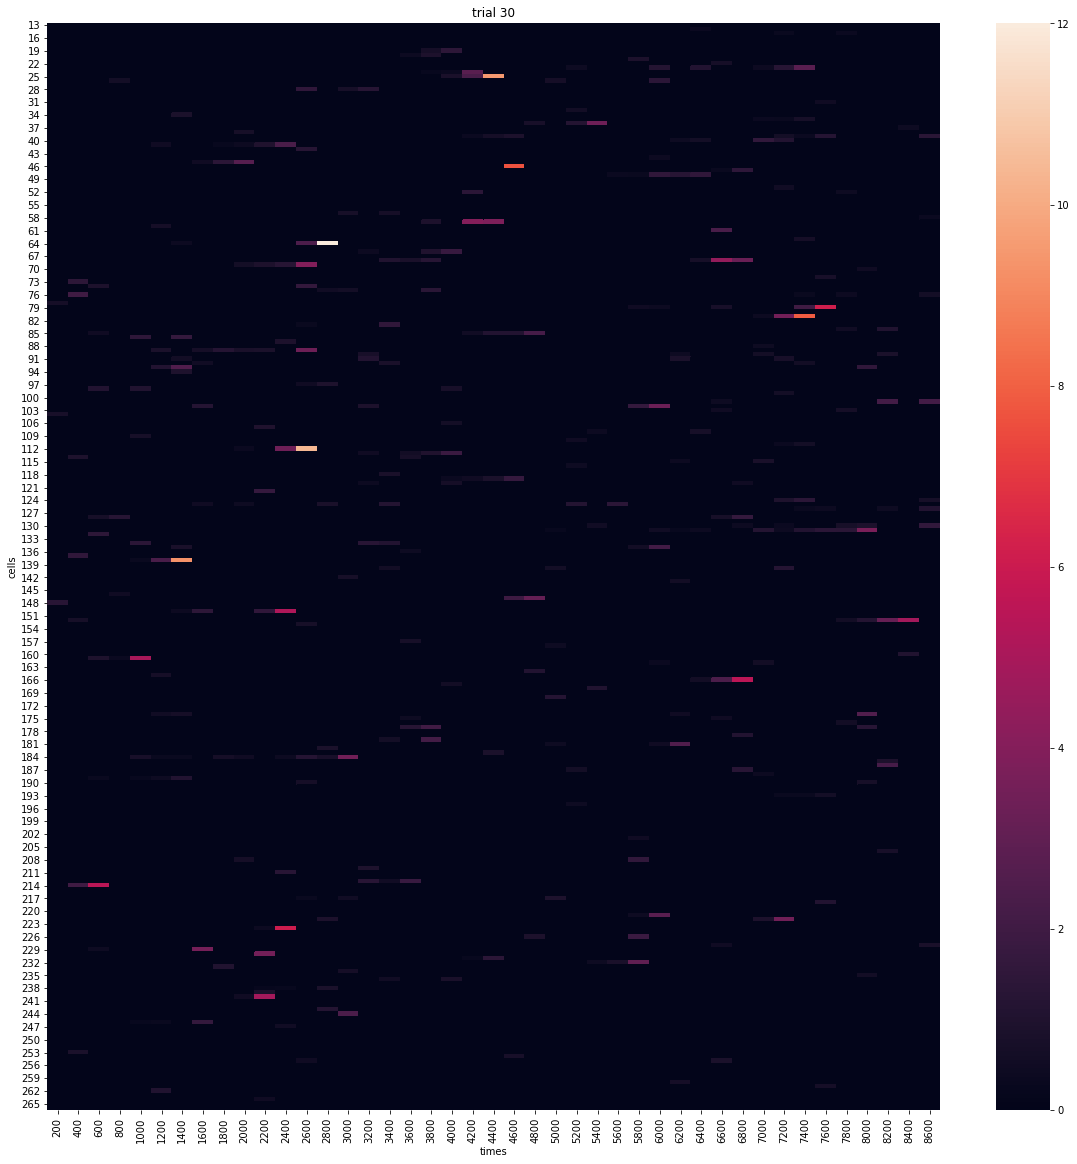

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 
#os.mkdir("./plots")
print("binned dic")

c=0
for trial,bin in binned_dic.items():
    #print("trial:", trial)
    times,cells,spikes = [],[],[]
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell<=12:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            #print("time:", time, "cell:", cell, "mean_act:", mean_activity)
            times.append(time)
            cells.append(cell)
            spikes.append(mean_activity)
    data_dic = {}
    data_dic["times"] = times
    data_dic["cells"] = cells
    data_dic["spikes"] = spikes

    df = pd.DataFrame.from_dict(data_dic)
    df = df.pivot(index='cells', columns='times', values='spikes')
    print(df.head())
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.title("trial "+str(trial))
    sns.heatmap(df, annot=False)
    plt.savefig("plots/trial"+str(trial)+".png")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 

times,cells,spikes,t = [],[],[],[]
data_dic = {}
for trial,bin in binned_dic.items():
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell <= 12:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            t.append(trial)
            times.append(time)
            cells.append(cell)
            spikes.append(mean_activity)
    #data_dic["trial"] = trials
    data_dic["trial"] = t
    data_dic["times"] = times
    data_dic["cells"] = cells
    data_dic["spikes"] = spikes

df = pd.DataFrame.from_dict(data_dic)

print(df.head())

   trial  times  cells  spikes
0      0    200     13     0.0
1      0    200     14     0.0
2      0    200     15     0.0
3      0    200     16     0.0
4      0    200     17     0.0


In [8]:
df1 = df.copy()
max_avg = {}
for i in range(0,10):
    df1["spikes"] = np.random.permutation(df["spikes"].values)
    avrg_spike = {}
    for i, j in df1.iterrows():
        time = int(j["times"])
        cell = int(j["cells"])
        spike = int(j["spikes"])
        if (time, cell) in avrg_spike:
            avrg_spike[(time,cell)].append(spike)
        else:
            avrg_spike[(time,cell)] = []
            avrg_spike[(time,cell)].append(spike)
    for k,v in avrg_spike.items():
        if k in max_avg:
            max_avg[k].append(max(v))
        else:
            max_avg[k] = []
            max_avg[k].append(max(v))

print(max_avg)

{(200, 13): [0, 0, 0, 0, 0, 0, 0, 1, 0, 1], (200, 14): [0, 1, 6, 0, 0, 0, 2, 1, 1, 0], (200, 15): [0, 0, 0, 0, 3, 1, 0, 0, 0, 0], (200, 16): [0, 4, 0, 0, 9, 1, 2, 0, 4, 1], (200, 17): [9, 0, 2, 0, 1, 1, 1, 0, 0, 0], (200, 18): [0, 0, 3, 2, 1, 1, 3, 1, 2, 0], (200, 19): [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], (200, 20): [0, 0, 0, 0, 0, 2, 2, 0, 6, 0], (200, 21): [1, 0, 1, 0, 0, 8, 0, 1, 0, 0], (200, 22): [1, 1, 0, 0, 1, 0, 2, 0, 0, 0], (200, 23): [1, 1, 0, 2, 2, 0, 1, 0, 1, 0], (200, 24): [0, 1, 0, 2, 0, 0, 0, 0, 1, 1], (200, 25): [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], (200, 26): [1, 1, 0, 2, 0, 0, 0, 0, 1, 0], (200, 27): [1, 8, 1, 0, 1, 2, 1, 0, 0, 0], (200, 28): [0, 0, 0, 0, 0, 0, 0, 1, 0, 1], (200, 29): [0, 0, 0, 0, 1, 0, 0, 1, 0, 0], (200, 30): [0, 0, 3, 0, 0, 0, 8, 2, 0, 2], (200, 31): [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], (200, 32): [0, 2, 0, 0, 0, 0, 0, 0, 0, 17], (200, 33): [0, 3, 1, 0, 0, 0, 0, 0, 0, 0], (200, 34): [0, 0, 0, 2, 0, 0, 0, 0, 5, 0], (200, 35): [1, 0, 1, 0, 0, 0, 0, 1, 0, 0], (200, 36)

In [ ]:
for i, j in df.iterrows():
        time = int(j["times"])
        cell = int(j["cells"])
        spike = int(j["spikes"])
        trial = int(j["trial"])
        arr = np.array(max_avg[(time,cell)])
        nintey_fifth_p = np.percentile(arr, 95)
        if spike > nintey_fifth_p:
            print("trial:", trial, "cell:", cell, "bin:", time)

trial: 0 cell: 54 bin: 400
trial: 0 cell: 54 bin: 600
trial: 0 cell: 184 bin: 600
trial: 0 cell: 24 bin: 800
trial: 0 cell: 58 bin: 800
trial: 0 cell: 98 bin: 800
trial: 0 cell: 170 bin: 800
trial: 0 cell: 24 bin: 1000
trial: 0 cell: 213 bin: 1000
trial: 0 cell: 227 bin: 1000
trial: 0 cell: 52 bin: 1200
trial: 0 cell: 169 bin: 1600
trial: 0 cell: 28 bin: 2000
trial: 0 cell: 243 bin: 2000
trial: 0 cell: 199 bin: 2200
trial: 0 cell: 154 bin: 2400
trial: 0 cell: 154 bin: 2600
trial: 0 cell: 164 bin: 2600
trial: 0 cell: 33 bin: 2800
trial: 0 cell: 52 bin: 2800
trial: 0 cell: 135 bin: 2800
trial: 0 cell: 203 bin: 3200
trial: 0 cell: 202 bin: 3400
trial: 0 cell: 54 bin: 3600
trial: 0 cell: 224 bin: 3800
trial: 0 cell: 224 bin: 4000
trial: 0 cell: 86 bin: 4400
trial: 0 cell: 201 bin: 4800
trial: 0 cell: 50 bin: 5200
trial: 0 cell: 36 bin: 5800
trial: 0 cell: 181 bin: 5800
trial: 0 cell: 184 bin: 5800
trial: 0 cell: 36 bin: 6000
trial: 0 cell: 48 bin: 6200
trial: 0 cell: 167 bin: 6200
trial: 0

In [20]:
for i, j in df.iterrows():
    time = int(j["times"])
    cell = int(j["cells"])
    spike = int(j["spikes"])
    trial = int(j["trial"])
    average = avrg_spike[(time,cell)]
    if spike > (3*average):
        print("trial:", trial, "cell:", cell, "bin:", time)

trial: 0 cell: 7 bin: 200
trial: 0 cell: 11 bin: 200
trial: 0 cell: 34 bin: 200
trial: 0 cell: 168 bin: 200
trial: 0 cell: 170 bin: 200
trial: 0 cell: 220 bin: 200
trial: 0 cell: 7 bin: 400
trial: 0 cell: 11 bin: 400
trial: 0 cell: 54 bin: 400
trial: 0 cell: 7 bin: 600
trial: 0 cell: 11 bin: 600
trial: 0 cell: 54 bin: 600
trial: 0 cell: 156 bin: 600
trial: 0 cell: 184 bin: 600
trial: 0 cell: 206 bin: 600
trial: 0 cell: 7 bin: 800
trial: 0 cell: 11 bin: 800
trial: 0 cell: 24 bin: 800
trial: 0 cell: 58 bin: 800
trial: 0 cell: 68 bin: 800
trial: 0 cell: 70 bin: 800
trial: 0 cell: 98 bin: 800
trial: 0 cell: 100 bin: 800
trial: 0 cell: 156 bin: 800
trial: 0 cell: 170 bin: 800
trial: 0 cell: 263 bin: 800
trial: 0 cell: 7 bin: 1000
trial: 0 cell: 24 bin: 1000
trial: 0 cell: 51 bin: 1000
trial: 0 cell: 52 bin: 1000
trial: 0 cell: 68 bin: 1000
trial: 0 cell: 213 bin: 1000
trial: 0 cell: 214 bin: 1000
trial: 0 cell: 227 bin: 1000
trial: 0 cell: 236 bin: 1000
trial: 0 cell: 7 bin: 1200
trial: 0 c

trial: 1 cell: 214 bin: 8000
trial: 1 cell: 236 bin: 8200
trial: 1 cell: 74 bin: 8400
trial: 1 cell: 77 bin: 8600
trial: 2 cell: 70 bin: 200
trial: 2 cell: 76 bin: 200
trial: 2 cell: 82 bin: 200
trial: 2 cell: 95 bin: 200
trial: 2 cell: 142 bin: 200
trial: 2 cell: 145 bin: 200
trial: 2 cell: 214 bin: 200
trial: 2 cell: 253 bin: 200
trial: 2 cell: 66 bin: 400
trial: 2 cell: 95 bin: 400
trial: 2 cell: 132 bin: 400
trial: 2 cell: 152 bin: 400
trial: 2 cell: 176 bin: 400
trial: 2 cell: 234 bin: 400
trial: 2 cell: 41 bin: 800
trial: 2 cell: 189 bin: 800
trial: 2 cell: 41 bin: 1000
trial: 2 cell: 89 bin: 1000
trial: 2 cell: 134 bin: 1000
trial: 2 cell: 189 bin: 1000
trial: 2 cell: 93 bin: 1200
trial: 2 cell: 134 bin: 1200
trial: 2 cell: 161 bin: 1200
trial: 2 cell: 193 bin: 1200
trial: 2 cell: 219 bin: 1200
trial: 2 cell: 54 bin: 1400
trial: 2 cell: 73 bin: 1400
trial: 2 cell: 74 bin: 1400
trial: 2 cell: 98 bin: 1400
trial: 2 cell: 144 bin: 1400
trial: 2 cell: 150 bin: 1400
trial: 2 cell: 22

trial: 3 cell: 134 bin: 4600
trial: 3 cell: 168 bin: 4600
trial: 3 cell: 177 bin: 4600
trial: 3 cell: 180 bin: 4600
trial: 3 cell: 102 bin: 4800
trial: 3 cell: 171 bin: 4800
trial: 3 cell: 20 bin: 5000
trial: 3 cell: 66 bin: 5000
trial: 3 cell: 118 bin: 5000
trial: 3 cell: 171 bin: 5000
trial: 3 cell: 88 bin: 5200
trial: 3 cell: 121 bin: 5200
trial: 3 cell: 255 bin: 5200
trial: 3 cell: 88 bin: 5400
trial: 3 cell: 141 bin: 5400
trial: 3 cell: 159 bin: 5400
trial: 3 cell: 226 bin: 5400
trial: 3 cell: 232 bin: 5400
trial: 3 cell: 35 bin: 5600
trial: 3 cell: 42 bin: 5600
trial: 3 cell: 66 bin: 5600
trial: 3 cell: 87 bin: 5600
trial: 3 cell: 222 bin: 5600
trial: 3 cell: 247 bin: 5600
trial: 3 cell: 34 bin: 5800
trial: 3 cell: 35 bin: 5800
trial: 3 cell: 106 bin: 5800
trial: 3 cell: 222 bin: 5800
trial: 3 cell: 255 bin: 5800
trial: 3 cell: 56 bin: 6000
trial: 3 cell: 125 bin: 6000
trial: 3 cell: 154 bin: 6000
trial: 3 cell: 190 bin: 6000
trial: 3 cell: 192 bin: 6000
trial: 3 cell: 206 bin: 6

trial: 5 cell: 97 bin: 4000
trial: 5 cell: 178 bin: 4000
trial: 5 cell: 205 bin: 4000
trial: 5 cell: 243 bin: 4000
trial: 5 cell: 244 bin: 4000
trial: 5 cell: 58 bin: 4200
trial: 5 cell: 97 bin: 4200
trial: 5 cell: 167 bin: 4200
trial: 5 cell: 41 bin: 4400
trial: 5 cell: 105 bin: 4400
trial: 5 cell: 57 bin: 4600
trial: 5 cell: 134 bin: 4600
trial: 5 cell: 18 bin: 4800
trial: 5 cell: 90 bin: 4800
trial: 5 cell: 210 bin: 4800
trial: 5 cell: 28 bin: 5000
trial: 5 cell: 90 bin: 5000
trial: 5 cell: 92 bin: 5000
trial: 5 cell: 171 bin: 5200
trial: 5 cell: 177 bin: 5200
trial: 5 cell: 102 bin: 5400
trial: 5 cell: 168 bin: 5400
trial: 5 cell: 180 bin: 5400
trial: 5 cell: 234 bin: 5400
trial: 5 cell: 66 bin: 5600
trial: 5 cell: 96 bin: 5600
trial: 5 cell: 113 bin: 5600
trial: 5 cell: 168 bin: 5600
trial: 5 cell: 204 bin: 5600
trial: 5 cell: 43 bin: 5800
trial: 5 cell: 68 bin: 5800
trial: 5 cell: 113 bin: 5800
trial: 5 cell: 225 bin: 5800
trial: 5 cell: 54 bin: 6000
trial: 5 cell: 89 bin: 6000
t

trial: 7 cell: 131 bin: 600
trial: 7 cell: 137 bin: 600
trial: 7 cell: 142 bin: 600
trial: 7 cell: 26 bin: 800
trial: 7 cell: 73 bin: 800
trial: 7 cell: 76 bin: 800
trial: 7 cell: 95 bin: 800
trial: 7 cell: 132 bin: 800
trial: 7 cell: 222 bin: 800
trial: 7 cell: 214 bin: 1000
trial: 7 cell: 219 bin: 1000
trial: 7 cell: 224 bin: 1400
trial: 7 cell: 261 bin: 1400
trial: 7 cell: 74 bin: 1600
trial: 7 cell: 98 bin: 1600
trial: 7 cell: 152 bin: 1600
trial: 7 cell: 159 bin: 1600
trial: 7 cell: 189 bin: 1600
trial: 7 cell: 70 bin: 1800
trial: 7 cell: 86 bin: 1800
trial: 7 cell: 94 bin: 1800
trial: 7 cell: 161 bin: 1800
trial: 7 cell: 162 bin: 1800
trial: 7 cell: 189 bin: 1800
trial: 7 cell: 262 bin: 1800
trial: 7 cell: 93 bin: 2000
trial: 7 cell: 189 bin: 2000
trial: 7 cell: 73 bin: 2200
trial: 7 cell: 86 bin: 2200
trial: 7 cell: 134 bin: 2200
trial: 7 cell: 51 bin: 2400
trial: 7 cell: 58 bin: 2400
trial: 7 cell: 222 bin: 2600
trial: 7 cell: 159 bin: 2800
trial: 7 cell: 107 bin: 3000
trial: 7

trial: 9 cell: 183 bin: 2400
trial: 9 cell: 205 bin: 2400
trial: 9 cell: 225 bin: 2400
trial: 9 cell: 74 bin: 2600
trial: 9 cell: 75 bin: 2600
trial: 9 cell: 117 bin: 2600
trial: 9 cell: 156 bin: 2600
trial: 9 cell: 184 bin: 2600
trial: 9 cell: 224 bin: 2600
trial: 9 cell: 261 bin: 2600
trial: 9 cell: 264 bin: 2600
trial: 9 cell: 28 bin: 2800
trial: 9 cell: 57 bin: 2800
trial: 9 cell: 97 bin: 2800
trial: 9 cell: 213 bin: 2800
trial: 9 cell: 244 bin: 2800
trial: 9 cell: 28 bin: 3000
trial: 9 cell: 64 bin: 3000
trial: 9 cell: 97 bin: 3000
trial: 9 cell: 134 bin: 3000
trial: 9 cell: 184 bin: 3000
trial: 9 cell: 243 bin: 3000
trial: 9 cell: 90 bin: 3200
trial: 9 cell: 162 bin: 3200
trial: 9 cell: 87 bin: 3400
trial: 9 cell: 90 bin: 3400
trial: 9 cell: 92 bin: 3400
trial: 9 cell: 34 bin: 3600
trial: 9 cell: 118 bin: 3600
trial: 9 cell: 247 bin: 3600
trial: 9 cell: 38 bin: 3800
trial: 9 cell: 194 bin: 3800
trial: 9 cell: 204 bin: 3800
trial: 9 cell: 219 bin: 3800
trial: 9 cell: 220 bin: 3800

trial: 11 cell: 86 bin: 1000
trial: 11 cell: 98 bin: 1000
trial: 11 cell: 135 bin: 1000
trial: 11 cell: 161 bin: 1000
trial: 11 cell: 259 bin: 1200
trial: 11 cell: 135 bin: 1400
trial: 11 cell: 21 bin: 1600
trial: 11 cell: 45 bin: 1600
trial: 11 cell: 52 bin: 1600
trial: 11 cell: 112 bin: 1600
trial: 11 cell: 134 bin: 1600
trial: 11 cell: 184 bin: 1600
trial: 11 cell: 189 bin: 1600
trial: 11 cell: 238 bin: 1600
trial: 11 cell: 54 bin: 1800
trial: 11 cell: 73 bin: 1800
trial: 11 cell: 109 bin: 1800
trial: 11 cell: 224 bin: 1800
trial: 11 cell: 58 bin: 2000
trial: 11 cell: 64 bin: 2000
trial: 11 cell: 222 bin: 2000
trial: 11 cell: 213 bin: 2200
trial: 11 cell: 104 bin: 2400
trial: 11 cell: 233 bin: 2400
trial: 11 cell: 246 bin: 2400
trial: 11 cell: 41 bin: 2600
trial: 11 cell: 49 bin: 2600
trial: 11 cell: 137 bin: 2600
trial: 11 cell: 156 bin: 2600
trial: 11 cell: 178 bin: 2600
trial: 11 cell: 184 bin: 2600
trial: 11 cell: 224 bin: 2600
trial: 11 cell: 243 bin: 2600
trial: 11 cell: 244 b

trial: 12 cell: 112 bin: 6000
trial: 12 cell: 179 bin: 6000
trial: 12 cell: 50 bin: 6200
trial: 12 cell: 130 bin: 6200
trial: 12 cell: 171 bin: 6200
trial: 12 cell: 216 bin: 6200
trial: 12 cell: 133 bin: 6400
trial: 12 cell: 171 bin: 6400
trial: 12 cell: 203 bin: 6400
trial: 12 cell: 204 bin: 6400
trial: 12 cell: 143 bin: 6600
trial: 12 cell: 190 bin: 6600
trial: 12 cell: 203 bin: 6600
trial: 12 cell: 51 bin: 6800
trial: 12 cell: 55 bin: 6800
trial: 12 cell: 239 bin: 6800
trial: 12 cell: 263 bin: 6800
trial: 12 cell: 23 bin: 7000
trial: 12 cell: 100 bin: 7000
trial: 12 cell: 162 bin: 7000
trial: 12 cell: 23 bin: 7200
trial: 12 cell: 35 bin: 7200
trial: 12 cell: 48 bin: 7200
trial: 12 cell: 32 bin: 7400
trial: 12 cell: 70 bin: 7400
trial: 12 cell: 98 bin: 7400
trial: 12 cell: 111 bin: 7400
trial: 12 cell: 144 bin: 7400
trial: 12 cell: 184 bin: 7400
trial: 12 cell: 127 bin: 7800
trial: 12 cell: 61 bin: 8000
trial: 12 cell: 70 bin: 8000
trial: 12 cell: 127 bin: 8000
trial: 12 cell: 184 bi

trial: 14 cell: 108 bin: 4400
trial: 14 cell: 118 bin: 4400
trial: 14 cell: 195 bin: 4400
trial: 14 cell: 196 bin: 4400
trial: 14 cell: 42 bin: 4600
trial: 14 cell: 66 bin: 4600
trial: 14 cell: 164 bin: 4600
trial: 14 cell: 180 bin: 4600
trial: 14 cell: 218 bin: 4600
trial: 14 cell: 34 bin: 4800
trial: 14 cell: 42 bin: 4800
trial: 14 cell: 106 bin: 4800
trial: 14 cell: 114 bin: 4800
trial: 14 cell: 146 bin: 4800
trial: 14 cell: 106 bin: 5000
trial: 14 cell: 34 bin: 5200
trial: 14 cell: 36 bin: 5400
trial: 14 cell: 119 bin: 5400
trial: 14 cell: 175 bin: 5400
trial: 14 cell: 36 bin: 5600
trial: 14 cell: 119 bin: 5600
trial: 14 cell: 242 bin: 5600
trial: 14 cell: 265 bin: 5600
trial: 14 cell: 28 bin: 5800
trial: 14 cell: 36 bin: 5800
trial: 14 cell: 48 bin: 5800
trial: 14 cell: 143 bin: 5800
trial: 14 cell: 170 bin: 5800
trial: 14 cell: 227 bin: 5800
trial: 14 cell: 100 bin: 6200
trial: 14 cell: 32 bin: 6400
trial: 14 cell: 55 bin: 6600
trial: 14 cell: 68 bin: 6600
trial: 14 cell: 234 bin

trial: 16 cell: 164 bin: 6400
trial: 16 cell: 185 bin: 6400
trial: 16 cell: 28 bin: 6600
trial: 16 cell: 55 bin: 6600
trial: 16 cell: 175 bin: 6600
trial: 16 cell: 50 bin: 6800
trial: 16 cell: 157 bin: 6800
trial: 16 cell: 205 bin: 6800
trial: 16 cell: 61 bin: 7400
trial: 16 cell: 108 bin: 7400
trial: 16 cell: 138 bin: 7400
trial: 16 cell: 239 bin: 7400
trial: 16 cell: 127 bin: 7600
trial: 16 cell: 128 bin: 7600
trial: 16 cell: 179 bin: 7600
trial: 16 cell: 181 bin: 7600
trial: 16 cell: 69 bin: 7800
trial: 16 cell: 127 bin: 7800
trial: 16 cell: 181 bin: 7800
trial: 16 cell: 36 bin: 8000
trial: 16 cell: 61 bin: 8000
trial: 16 cell: 69 bin: 8000
trial: 16 cell: 110 bin: 8000
trial: 16 cell: 131 bin: 8000
trial: 16 cell: 187 bin: 8000
trial: 16 cell: 61 bin: 8200
trial: 16 cell: 203 bin: 8200
trial: 16 cell: 176 bin: 8400
trial: 16 cell: 208 bin: 8400
trial: 16 cell: 27 bin: 8600
trial: 16 cell: 50 bin: 8600
trial: 16 cell: 208 bin: 8600
trial: 17 cell: 31 bin: 200
trial: 17 cell: 76 bin:

trial: 18 cell: 91 bin: 8600
trial: 18 cell: 176 bin: 8600
trial: 18 cell: 203 bin: 8600
trial: 18 cell: 221 bin: 8600
trial: 19 cell: 137 bin: 400
trial: 19 cell: 143 bin: 600
trial: 19 cell: 152 bin: 600
trial: 19 cell: 73 bin: 800
trial: 19 cell: 76 bin: 800
trial: 19 cell: 128 bin: 800
trial: 19 cell: 132 bin: 800
trial: 19 cell: 214 bin: 800
trial: 19 cell: 215 bin: 800
trial: 19 cell: 70 bin: 1000
trial: 19 cell: 98 bin: 1400
trial: 19 cell: 109 bin: 1400
trial: 19 cell: 145 bin: 1400
trial: 19 cell: 161 bin: 1400
trial: 19 cell: 246 bin: 1400
trial: 19 cell: 161 bin: 1600
trial: 19 cell: 194 bin: 1600
trial: 19 cell: 208 bin: 1800
trial: 19 cell: 52 bin: 2000
trial: 19 cell: 73 bin: 2000
trial: 19 cell: 238 bin: 2200
trial: 19 cell: 254 bin: 2400
trial: 19 cell: 152 bin: 2600
trial: 19 cell: 176 bin: 2600
trial: 19 cell: 86 bin: 2800
trial: 19 cell: 134 bin: 2800
trial: 19 cell: 52 bin: 3000
trial: 19 cell: 58 bin: 3000
trial: 19 cell: 86 bin: 3000
trial: 19 cell: 134 bin: 3000


trial: 20 cell: 211 bin: 8200
trial: 20 cell: 218 bin: 8200
trial: 20 cell: 89 bin: 8400
trial: 20 cell: 114 bin: 8400
trial: 20 cell: 114 bin: 8600
trial: 20 cell: 186 bin: 8600
trial: 20 cell: 218 bin: 8600
trial: 21 cell: 130 bin: 200
trial: 21 cell: 216 bin: 400
trial: 21 cell: 231 bin: 400
trial: 21 cell: 134 bin: 800
trial: 21 cell: 86 bin: 1000
trial: 21 cell: 109 bin: 1000
trial: 21 cell: 134 bin: 1000
trial: 21 cell: 86 bin: 1200
trial: 21 cell: 135 bin: 1200
trial: 21 cell: 189 bin: 1200
trial: 21 cell: 213 bin: 1200
trial: 21 cell: 64 bin: 1400
trial: 21 cell: 93 bin: 1400
trial: 21 cell: 208 bin: 1600
trial: 21 cell: 28 bin: 1800
trial: 21 cell: 102 bin: 1800
trial: 21 cell: 250 bin: 1800
trial: 21 cell: 41 bin: 2000
trial: 21 cell: 64 bin: 2000
trial: 21 cell: 224 bin: 2000
trial: 21 cell: 239 bin: 2000
trial: 21 cell: 246 bin: 2000
trial: 21 cell: 49 bin: 2200
trial: 21 cell: 64 bin: 2200
trial: 21 cell: 107 bin: 2200
trial: 21 cell: 128 bin: 2200
trial: 21 cell: 184 bin:

trial: 23 cell: 142 bin: 1200
trial: 23 cell: 214 bin: 1200
trial: 23 cell: 76 bin: 1400
trial: 23 cell: 132 bin: 1400
trial: 23 cell: 149 bin: 1400
trial: 23 cell: 158 bin: 1400
trial: 23 cell: 210 bin: 1400
trial: 23 cell: 214 bin: 1400
trial: 23 cell: 154 bin: 1800
trial: 23 cell: 214 bin: 1800
trial: 23 cell: 180 bin: 2000
trial: 23 cell: 205 bin: 2000
trial: 23 cell: 37 bin: 2200
trial: 23 cell: 161 bin: 2200
trial: 23 cell: 189 bin: 2200
trial: 23 cell: 205 bin: 2200
trial: 23 cell: 88 bin: 2400
trial: 23 cell: 161 bin: 2400
trial: 23 cell: 189 bin: 2400
trial: 23 cell: 73 bin: 2600
trial: 23 cell: 86 bin: 2600
trial: 23 cell: 98 bin: 2600
trial: 23 cell: 238 bin: 2600
trial: 23 cell: 213 bin: 3000
trial: 23 cell: 152 bin: 3200
trial: 23 cell: 86 bin: 3400
trial: 23 cell: 134 bin: 3400
trial: 23 cell: 145 bin: 3400
trial: 23 cell: 38 bin: 3600
trial: 23 cell: 58 bin: 3600
trial: 23 cell: 134 bin: 3600
trial: 23 cell: 185 bin: 3600
trial: 23 cell: 208 bin: 3600
trial: 23 cell: 58 

trial: 25 cell: 76 bin: 800
trial: 25 cell: 132 bin: 800
trial: 25 cell: 98 bin: 1000
trial: 25 cell: 145 bin: 1000
trial: 25 cell: 152 bin: 1000
trial: 25 cell: 214 bin: 1000
trial: 25 cell: 86 bin: 1400
trial: 25 cell: 98 bin: 1400
trial: 25 cell: 233 bin: 1400
trial: 25 cell: 94 bin: 1600
trial: 25 cell: 135 bin: 1600
trial: 25 cell: 175 bin: 1600
trial: 25 cell: 185 bin: 1600
trial: 25 cell: 98 bin: 1800
trial: 25 cell: 185 bin: 1800
trial: 25 cell: 238 bin: 1800
trial: 25 cell: 250 bin: 1800
trial: 25 cell: 28 bin: 2200
trial: 25 cell: 64 bin: 2200
trial: 25 cell: 89 bin: 2200
trial: 25 cell: 107 bin: 2200
trial: 25 cell: 128 bin: 2200
trial: 25 cell: 150 bin: 2200
trial: 25 cell: 213 bin: 2200
trial: 25 cell: 224 bin: 2200
trial: 25 cell: 246 bin: 2200
trial: 25 cell: 21 bin: 2400
trial: 25 cell: 27 bin: 2400
trial: 25 cell: 45 bin: 2400
trial: 25 cell: 64 bin: 2400
trial: 25 cell: 87 bin: 2400
trial: 25 cell: 102 bin: 2400
trial: 25 cell: 45 bin: 2600
trial: 25 cell: 64 bin: 260

trial: 27 cell: 120 bin: 400
trial: 27 cell: 76 bin: 800
trial: 27 cell: 109 bin: 800
trial: 27 cell: 132 bin: 800
trial: 27 cell: 143 bin: 800
trial: 27 cell: 152 bin: 800
trial: 27 cell: 214 bin: 800
trial: 27 cell: 229 bin: 800
trial: 27 cell: 98 bin: 1000
trial: 27 cell: 98 bin: 1200
trial: 27 cell: 145 bin: 1200
trial: 27 cell: 86 bin: 1400
trial: 27 cell: 52 bin: 1600
trial: 27 cell: 175 bin: 1600
trial: 27 cell: 185 bin: 1600
trial: 27 cell: 213 bin: 1800
trial: 27 cell: 246 bin: 1800
trial: 27 cell: 45 bin: 2000
trial: 27 cell: 50 bin: 2000
trial: 27 cell: 122 bin: 2000
trial: 27 cell: 45 bin: 2200
trial: 27 cell: 49 bin: 2200
trial: 27 cell: 89 bin: 2200
trial: 27 cell: 136 bin: 2400
trial: 27 cell: 150 bin: 2400
trial: 27 cell: 208 bin: 2400
trial: 27 cell: 42 bin: 2600
trial: 27 cell: 69 bin: 2600
trial: 27 cell: 87 bin: 2600
trial: 27 cell: 89 bin: 2600
trial: 27 cell: 91 bin: 2600
trial: 27 cell: 41 bin: 2800
trial: 27 cell: 69 bin: 2800
trial: 27 cell: 112 bin: 2800
trial

trial: 29 cell: 89 bin: 2200
trial: 29 cell: 150 bin: 2200
trial: 29 cell: 38 bin: 2400
trial: 29 cell: 41 bin: 2400
trial: 29 cell: 69 bin: 2400
trial: 29 cell: 128 bin: 2400
trial: 29 cell: 182 bin: 2400
trial: 29 cell: 38 bin: 2600
trial: 29 cell: 42 bin: 2600
trial: 29 cell: 69 bin: 2600
trial: 29 cell: 107 bin: 2600
trial: 29 cell: 128 bin: 2600
trial: 29 cell: 42 bin: 2800
trial: 29 cell: 91 bin: 2800
trial: 29 cell: 150 bin: 2800
trial: 29 cell: 230 bin: 2800
trial: 29 cell: 243 bin: 2800
trial: 29 cell: 92 bin: 3000
trial: 29 cell: 124 bin: 3000
trial: 29 cell: 153 bin: 3000
trial: 29 cell: 210 bin: 3000
trial: 29 cell: 83 bin: 3200
trial: 29 cell: 90 bin: 3200
trial: 29 cell: 97 bin: 3200
trial: 29 cell: 68 bin: 3400
trial: 29 cell: 113 bin: 3600
trial: 29 cell: 136 bin: 3600
trial: 29 cell: 247 bin: 3600
trial: 29 cell: 19 bin: 3800
trial: 29 cell: 59 bin: 3800
trial: 29 cell: 66 bin: 3800
trial: 29 cell: 196 bin: 3800
trial: 29 cell: 213 bin: 3800
trial: 29 cell: 219 bin: 38